In [25]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd; pd.set_option("display.max_columns", None)

import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import matplotlib.pyplot as plt
import random
# import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm import tqdm
from tqdm.notebook import trange
import time

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import fine_time_coupling_model
import smoothing_spline
import util
import hierarchical_sampling_model
import hierarchical_model_generator
import jitter


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import allensdk
import pandas
import h5py
import pynwb
import hdmf
import matplotlib
import scipy
print('allensdk', allensdk.__version__)
print('pandas', pandas.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)
print('matplotlib', matplotlib.__version__)
print('scipy', scipy.__version__)

allensdk 2.2.0
pandas 1.3.5
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0
matplotlib 3.4.1
scipy 1.6.2


# Data generator

#### Poisson

In [645]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
lmbd_0, lmbd_1 = 20, 20
trial_length, num_trials = 2, 500
spike_times_x = generator.generate_poisson_spike_times(lmbd_0, trial_length, num_trials)
spike_times_y = generator.generate_poisson_spike_times(lmbd_1, trial_length, num_trials)

#### Hawkes process

In [659]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 2
generator_par = {'trial_length': trial_length, 'trial_window':[0, trial_length], 'num_trials': 500, 'random_seed': None,
    'type': 'triangle', 'mu': [20., 20.], 'alpha': [[0., 0], [0.0, 0.0]], 'beta': [[1.0, 0.05], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_hawkes_spike_times(generator_par, verbose=2)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

lambda stable: [20. 20.]
Gamma
[[0. 0.]
 [0. 0.]]
100%|█████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 53.76it/s]


#### Amarasingham + coupling filter (Repeated trials)

Laplace window.

In [160]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 2
trial_window = [0, trial_length]
generator_par = {'num_trials': 250, 'trial_length': trial_length, 'trial_window': trial_window,
    'num_peaks': 50, 'baseline': 10, 'sigma': 0.04, 'random_seed': 2,
    'type': 'square', 'alpha': [[0., 4], [0.0, 0.0]], 'beta': [[1.0, 0.04], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times(generator_par, verbose=2)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

lambda_max (proposal): 394.61
lambda stable: [105.96  91.34]
100%|█████████████████████████████████████████████████████████████| 250/250 [00:26<00:00,  9.27it/s]


Gaussian window.

In [300]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
generator_par = {'num_trials': 200, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 30, 'mu': 30, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': 3,
    'type': 'square', 'alpha': [[0., 2], [0.0, 0.0]], 'beta': [[1.0, 0.03], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times(generator_par, verbose=2)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

lambda_max (proposal): 248.8
lambda stable: [64.01 60.39]
100%|█████████████████████████████████████████████████████████████| 200/200 [00:42<00:00,  4.67it/s]


#### Amarasingham (fixed number of peaks) coupling filter (Non-repeated trials)

Laplace window.

In [3]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 2
trial_window = [0, trial_length]
generator_par = {'num_trials': 50, 'trial_length': trial_length, 'trial_window': trial_window,
    'num_peaks': 30, 'baseline': 10, 'sigma': 0.04, 'random_seed': 6,
    'type': 'square', 'alpha': [[0., 3], [0.0, 0.0]], 'beta': [[1.0, 0.04], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=2)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

100%|███████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.80it/s]


#### Linear Cox + Gaussian window.

In [564]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
generator_par = {'num_trials': 100, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 30, 'mu': 30, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': 222,
    'type': 'square', 'alpha': [[0., 2], [0.0, 0.0]], 'beta': [[1.0, 0.03], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=2)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

100%|█████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.86it/s]


#### Linear Cox coupling filter varying $\sigma_I$ (Non-repeated trials)

layers 3, nodes 2, trials 1
meanFR [12.4 11. ]	meanISI [12.934 10.932]


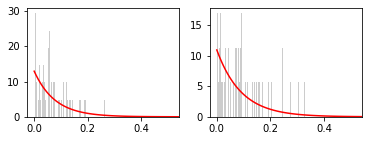

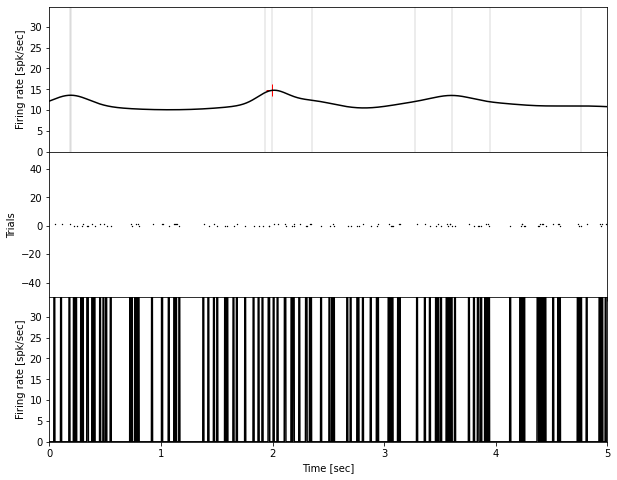

layers 3, nodes 2, trials 2
meanFR [12.7 11.2]	meanISI [13.979 11.309]


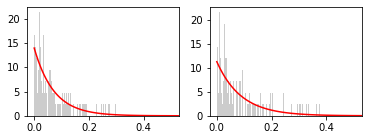

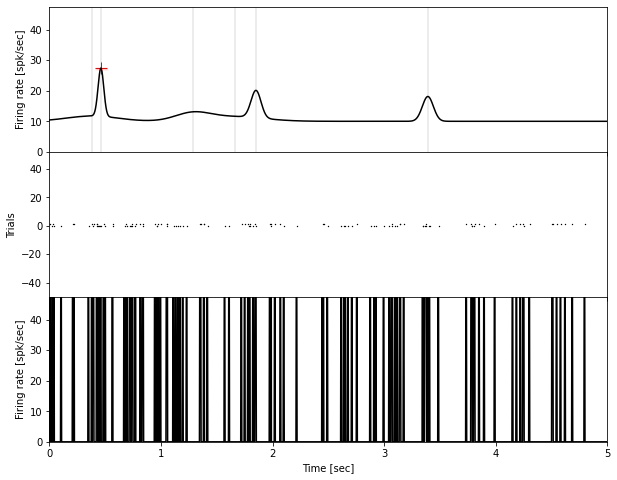

layers 3, nodes 2, trials 3
meanFR [12.933 10.733]	meanISI [13.824 10.765]


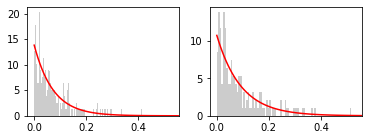

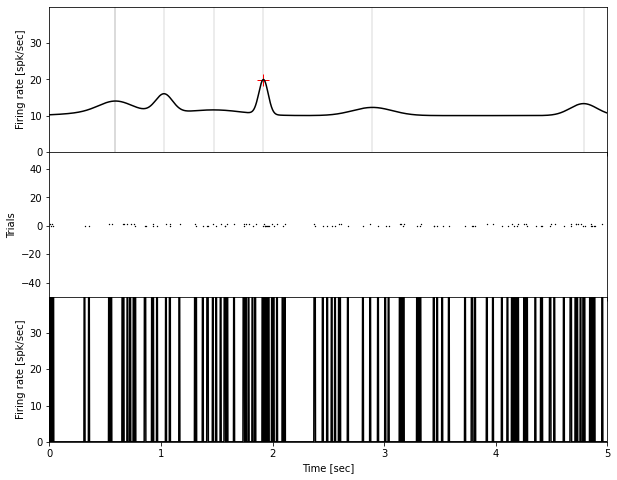

layers 3, nodes 2, trials 4
meanFR [12.3  10.25]	meanISI [13.033 10.317]


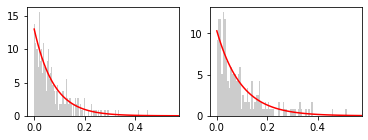

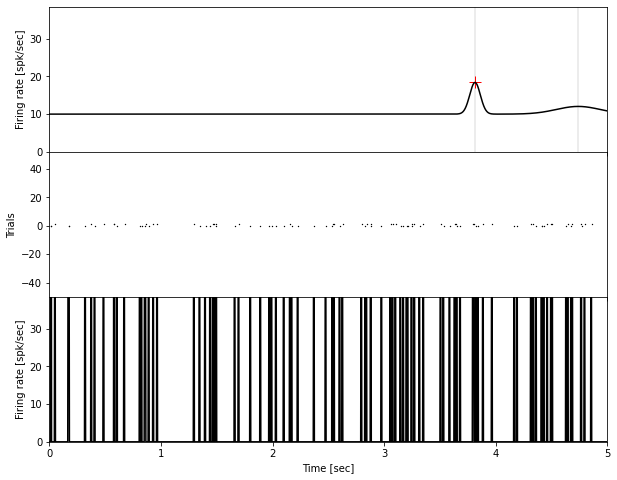

In [626]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
generator_par = {'num_trials': 4, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 1, 'mu': 1, 'baseline': 10, 'window': 'gaussian_varying', 'sigma': [0.02, 0.4], 'random_seed': 2222,
    'type': 'square', 'alpha': [[0., 2], [0.0, 0.0]], 'beta': [[1.0, 0.03], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=1)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

#### Linear Cox coupling filter timescale injection of non-shared slow-rate activities (Repeated trials)

layers 3, nodes 2, trials 200
meanFR [17.938 14.912]	meanISI [18.434 15.215]


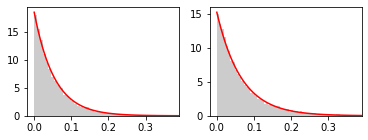

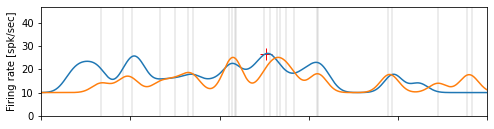

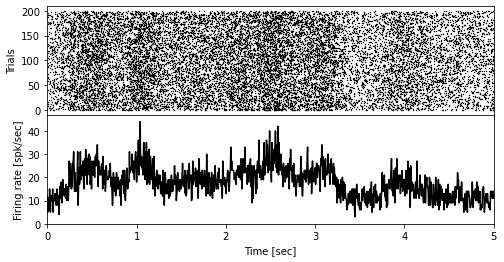

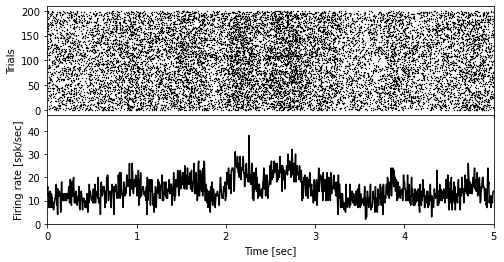

In [685]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
generator_par = {'num_trials': 200, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 3, 'mu': 3, 'rho_injection': 3, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': 2,
    'type': 'square', 'alpha': [[0.0, 2], [0.0, 0.0]], 'beta': [[0.0, 0.03], [0.0, 0.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times_inject_nonshared(generator_par, verbose=1)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

#### Linear Cox coupling filter timescale injection of non-shared slow-rate activities (Non-repeated trials)

In [705]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
generator_par = {'num_trials': 1000, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 5, 'mu': 5, 'rho_injection': 5, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': 2,
    'type': 'square', 'alpha': [[0.0, 4], [0.0, 0.0]], 'beta': [[0.0, 0.05], [0.0, 0.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times_inject_nonshared_nonrepeated(generator_par, verbose=1)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

100%|███████████████████████████████████████████████████████████| 1000/1000 [01:02<00:00, 15.94it/s]


#### Linear Cox coupling filter timescale inhomo-injection slow-rate activities (Repeated trials)
Neurons have different injections. <br>
This is suggested by Fengpei for model justification.

pars [(array([5.71874087e-04, 9.14413867e-02, 1.36937966e-01, 1.95273916e-01, 4.25221057e-01, 4.61692974e-01,
       4.91734169e-01, 5.16130033e-01, 6.50142861e-01, 7.01934693e-01, 7.33779454e-01, 8.49152098e-01,
       9.31301057e-01, 9.90507445e-01, 1.02226125e+00, 1.40221996e+00, 1.43887669e+00, 1.46807074e+00,
       1.51166286e+00, 1.56712089e+00, 1.57757816e+00, 1.72780364e+00, 1.98383737e+00, 2.08652401e+00,
       2.09597257e+00, 2.10553813e+00, 2.23946763e+00, 2.66582642e+00, 2.69408367e+00, 2.79344914e+00,
       3.35233755e+00, 3.42609750e+00, 3.43250464e+00, 3.45938557e+00, 3.46161308e+00, 3.74082827e+00,
       3.75072157e+00, 3.94639664e+00, 4.00372284e+00, 4.17312836e+00, 4.38194576e+00, 4.39058718e+00,
       4.39071252e+00, 4.47303332e+00, 4.54297752e+00, 4.78944765e+00, 4.84130788e+00, 4.94430544e+00]), 0.1, 20), (array([], dtype=float64), 0.1, 20)]
layers 3, nodes 2, trials 5
meanFR [30.72 19.72]	meanISI [31.029 19.948]


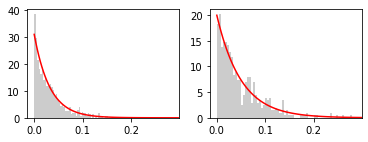

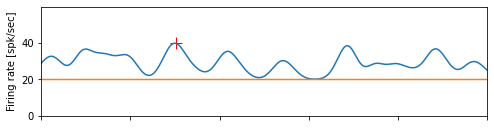

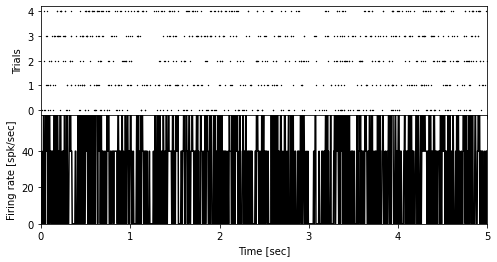

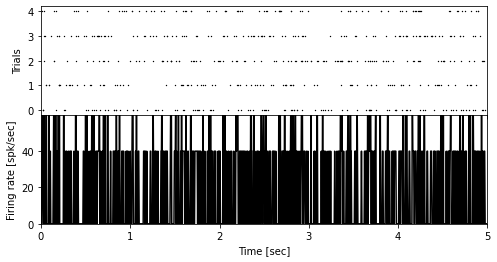

In [30]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
generator_par = {'num_trials': 5, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 0, 'mu': 0, 'rho_injection': [10, 0], 'baseline': 20, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': 1,
    'type': 'square', 'alpha': [[0.0, 2], [0.0, 0.0]], 'beta': [[0.0, 0.03], [0.0, 0.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times_inhomo_inject_nonshared(generator_par, verbose=1)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

#### Linear Cox coupling filter timescale inhomo-injection slow-rate activities (non-repeated)

In [40]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
generator_par = {'num_trials': 500, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 0, 'mu': 0, 'rho_injection': [10, 0], 'baseline': 20, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': 1,
    'type': 'square', 'alpha': [[0.0, 5], [0.0, 0.0]], 'beta': [[0.0, 0.03], [0.0, 0.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times_inhomo_inject_nonshared_nonrepeated(generator_par, verbose=0)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

#### Linear Cox + Laplacian window + coupling filter (Non-repeated trials)

In [32]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 2
trial_window = [0, trial_length]
generator_par = {'num_trials': 2, 'trial_length': trial_length, 'trial_window': trial_window,
    'num_peaks': 30, 'baseline': 10, 'sigma': 0.1, 'random_seed': 6,
    'type': 'square', 'alpha': [[0., 2], [0.0, 0.0]], 'beta': [[1.0, 0.04], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=1)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

## Check data statistics.

layers 3, nodes 2, trials 500
meanFR [32.884 19.94 ]	meanISI [33.151 20.141]


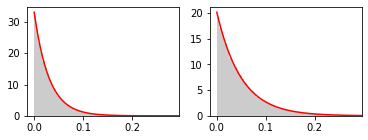

layers 3, nodes 2, trials 500


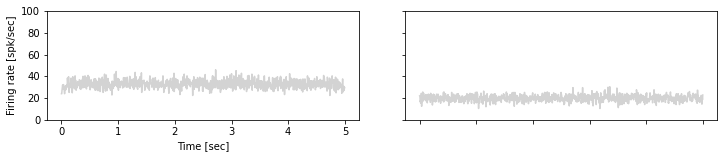

In [41]:
generator.spike_times_statistics(spike_times, generator_par['trial_length'], verbose=1)
_=generator.plot_psth(spike_times, generator_par['trial_length'], 0.005, ylim=[0, 100])
# generator.plot_hawkes_psth(spike_times, trial_length, 0.2, filter_par)
# generator.plot_hawkes_intensity(filter_par, spike_times, trial_length, node_ids=[0,1], trial_ids=[0], plot_window=[0, 0.5], ylim=[None, None])

### Jitter detection.

100%|█████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 38.15it/s]


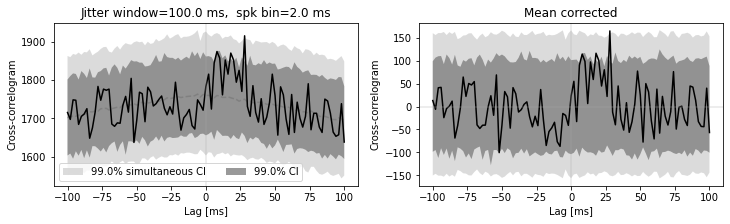

In [379]:
jittertool = jitter.JitterTool()
length = trial_length
spk_bin_width = 0.002
lag_range = [-0.1, 0.1]
jitter_window_width = 0.1
num_jitter = 500
distribution_type='mc_sim' # poisson, binom, mc_sim

_ = jittertool.cross_correlation_jitter(spike_times_x, spike_times_y, spk_bin_width, length, lag_range, 
    jitter_window_width=jitter_window_width, distribution_type=distribution_type, num_jitter=num_jitter, ci_alpha=0.01, verbose=2)

### Estimation of covariace density.

num_trials 100  trial_length 5


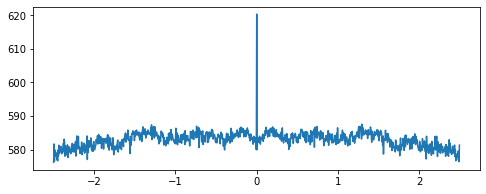

In [374]:
model_par = {'dt': 0.005, 'filter_type': 'square', 'filter_length': 0.03, 'trial_window': [0, trial_length],
             'append_nuisance': ['const', 'gaussian_kernel']}
true_model = generator_par
model_par_hat = jittertool.covariance_density(spike_times_x, model_par, true_par=generator_par)


# Discrete v.s continuous.

#### Gaussian.

In [1456]:
model_par = {'filter_type': 'square', 'filter_length': 0.04,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.08,
             'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
    spike_times_x[:200], spike_times_y[:200], [0, trial_length], model_par, verbose=True)

X.shape (45196, 3), basis_integral.shape (3, 1),beta.shape(3, 1)
 23%|██████████████                                               | 23/100 [00:00<00:00, 207.75it/s]
num itr 23 [[-128482.98139473]] 5.552443079759328e-07
beta [45.19599974  0.53993859  3.25347769]
gradient [-4.94442156e-06 -3.75060260e-04 -3.13293550e-05]


In [1462]:
model_par = {'filter_type': 'none',
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.08,
             'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
    spike_times_x[:100], spike_times_y[:100], [0, trial_length], model_par, verbose=True)

X.shape (22763, 2), basis_integral.shape (2, 1),beta.shape(2, 1)
 22%|█████████████▍                                               | 22/100 [00:00<00:00, 386.99it/s]
num itr 22 [[-64821.87516973]] 5.507536271487368e-07
beta [45.52599952  0.71019332]
gradient [-4.51833398e-06 -3.82084172e-04]


In [1458]:
model_par_discrete = {'dt': 0.001, 'filter_type': 'square', 'filter_length': 0.04,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.08,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par_discrete_hat = jittertool.bivariate_discrete_time_coupling_filter_regression(
        spike_times_x[:200], spike_times_y[:200], trial_window, model_par_discrete, verbose=True)

discrete integral    [[ 1.00000000e+03 -1.63027281e-11 -5.34677915e-11]]
continuous integral  [[1000.    0.    0.]]
num spikes x 40310 y 45196
X.shape (1000000, 3)
continuous integral  [[1000.    0.    0.]]
discrete integral    [[ 1.00000000e+03 -1.63027281e-11 -5.34677915e-11]]
itr0	nll: -127046.3	beta: [42.78041366  0.46712966  2.18826312]
itr1	nll: -128380.5	beta: [44.67438454  0.52594333  2.99607271]
itr2	nll: -128478.3	beta: [45.11099284  0.53789676  3.21098176]
itr3	nll: -128482.9	beta: [45.18322507  0.53974991  3.24804633]
itr4	nll: -128483.0	beta: [45.19410728  0.54002163  3.25370621]
itr5	nll: -128483.0	beta: [45.1957202   0.54006116  3.25455208]
itr6	nll: -128483.0	beta: [45.19595865  0.54006691  3.25467804]
itr7	nll: -128483.0	beta: [45.19599389  0.54006775  3.25469679]
itr8	nll: -128483.0	beta: [45.1959991   0.54006787  3.25469957]
itr9	nll: -128483.0	beta: [45.19599987  0.54006788  3.25469999]


In [1461]:
model_par_discrete = {'dt': 0.001, 'filter_type': 'none',
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.08,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par_discrete_hat = jittertool.bivariate_discrete_time_coupling_filter_regression(
        spike_times_x[:100], spike_times_y[:100], trial_window, model_par_discrete, verbose=True)

discrete integral    [[ 5.00000000e+02 -7.76350362e-12]]
continuous integral  [[500.   0.]]
num spikes x 20142 y 22763
X.shape (500000, 2)
continuous integral  [[500.   0.]]
discrete integral    [[ 5.00000000e+02 -7.76350362e-12]]
itr0	nll: -64152.6	beta: [43.23011245  0.58669634]
itr1	nll: -64779.9	beta: [45.05310515  0.6843629 ]
itr2	nll: -64820.1	beta: [45.45079733  0.70605951]
itr3	nll: -64821.8	beta: [45.51482319  0.70956429]
itr4	nll: -64821.9	beta: [45.52435734  0.71008885]
itr5	nll: -64821.9	beta: [45.52575894  0.71016636]
itr6	nll: -64821.9	beta: [45.52596463  0.71017779]
itr7	nll: -64821.9	beta: [45.52599481  0.71017947]
itr8	nll: -64821.9	beta: [45.52599924  0.71017972]


#### Triangle.

In [1307]:
model_par = {'filter_type': 'square', 'filter_length': 0.03,
             'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': 0.8,
             'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 1000, 'epsilon': 1e-6}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
    spike_times_x[:200], spike_times_y[:200], [0, trial_length], model_par, verbose=True)

X.shape (42034, 3), basis_integral.shape (3, 1),beta.shape(3, 1)
  2%|█▎                                                          | 21/1000 [00:00<00:03, 256.83it/s]
num itr 21 [[-115703.37399712]] 8.966147900801857e-07
beta [39.72356514  0.52554156  1.93635086]
gradient [-6.38690369e-06 -7.18941809e-04 -5.95175645e-05]


In [1271]:
model_par_discrete = {'dt': 0.001, 'filter_type': 'square', 'filter_length': 0.03,
             'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': 0.07,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par_discrete_hat = jittertool.bivariate_discrete_time_coupling_filter_regression(
        spike_times_x[:5], spike_times_y[:5], trial_window, model_par_discrete)

discrete integral    [[2.50000000e+01 1.53715604e-02 2.94730000e+01]]
continuous integral  [[25.    0.   29.52]]
num spikes x 984 y 1001
X.shape (25000, 3)
continuous integral  [[25.    0.   29.52]]
discrete integral    [[2.50000000e+01 1.53715604e-02 2.94730000e+01]]
itr0	nll: -2692.6	beta: [37.9567328   0.09924456  1.36183564]
itr1	nll: -2698.5	beta: [38.03172766  0.11883005  1.6277809 ]
itr2	nll: -2698.7	beta: [38.06484399  0.12243168  1.66385542]
itr3	nll: -2698.7	beta: [38.07199842  0.12300739  1.66758782]
itr4	nll: -2698.7	beta: [38.07328533  0.12309569  1.66792775]
itr5	nll: -2698.7	beta: [38.07349931  0.12310901  1.66795352]
itr6	nll: -2698.7	beta: [38.07353338  0.123111    1.66795455]
itr7	nll: -2698.7	beta: [38.07353865  0.1231113   1.66795439]


#### Square.

In [997]:
model_par = {'filter_type': 'square', 'filter_length': 0.03,
             'append_nuisance': ['const', 'square_kernel'], 'kernel_width': 0.1,
             'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 1000, 'epsilon': 1e-6}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
    spike_times_x[:155], spike_times_y[:155], [0, trial_length], model_par, verbose=True)

X.shape (32715, 3), basis_integral.shape (3, 1),beta.shape(3, 1)
  2%|█▎                                                          | 22/1000 [00:00<00:03, 294.11it/s]
num itr 22 [[-89985.68804803]] 5.809243531773589e-07
beta [39.6094072   0.15290924  2.20753535]
gradient [ 1.16368142e-07 -2.61604584e-04 -1.53208317e-05]


In [972]:
model_par_discrete = {'dt': 0.001, 'filter_type': 'square', 'filter_length': 0.03,
             'append_nuisance': ['const', 'square_kernel'], 'kernel_width': 3,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
beta=jittertool.bivariate_discrete_time_coupling_filter_regression(
        spike_times_x[:5], spike_times_y[:5], trial_window, model_par_discrete)

num spikes x 1011 y 1112
continuous integral  [[25.    0.   30.33]]
discrete integral    [[2.50000000e+01 4.20189598e-03 3.02940000e+01]]


##### Discrete optimization verification (L2 loss)

In [ ]:
model_par_discrete = {'dt': 0.001, 'filter_type': 'square', 'filter_length': 0.04,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.08,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par_discrete_hat = jittertool.bivariate_discrete_time_coupling_filter_regression_L2_loss(
    spike_times_x[:200], spike_times_y[:200], trial_window, model_par_discrete, verbose=True)

In [1464]:
model_par_discrete = {'dt': 0.001, 'filter_type': 'none',
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.08,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par_discrete_hat = jittertool.bivariate_discrete_time_coupling_filter_regression_L2_loss(
    spike_times_x[:100], spike_times_y[:100], trial_window, model_par_discrete, verbose=True)

num spikes x 20142 y 22763
X.shape (5000000, 2) beta.shape (2, 1)

itr0	loss: 22789.2	beta: [45.526       0.31187819]
itr1	loss: 22788.0	beta: [45.526      0.4834112]
itr2	loss: 22787.6	beta: [45.526       0.57775435]
itr3	loss: 22787.5	beta: [45.526       0.62964309]
itr4	loss: 22787.4	beta: [45.526       0.65818189]
itr5	loss: 22787.4	beta: [45.526       0.67387824]
itr6	loss: 22787.4	beta: [45.526       0.68251122]
itr7	loss: 22787.4	beta: [45.526       0.68725937]
itr8	loss: 22787.4	beta: [45.526       0.68987085]
itr9	loss: 22787.4	beta: [45.526       0.69130716]
itr10	loss: 22787.4	beta: [45.526       0.69209713]
itr11	loss: 22787.4	beta: [45.526       0.69253162]
itr12	loss: 22787.4	beta: [45.526       0.69277058]
itr13	loss: 22787.4	beta: [45.526       0.69290201]
itr14	loss: 22787.4	beta: [45.526      0.6929743]
itr15	loss: 22787.4	beta: [45.526       0.69301406]
itr16	loss: 22787.4	beta: [45.526       0.69303593]
itr17	loss: 22787.4	beta: [45.526       0.69304795]
itr18	loss:

# Numerical + theoretical analysis

In [1019]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/'
model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated'
file_path = data_dir + f'{model_name}_generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
model_par_list = []

kernel_width = 'none'  # ms

model_par = {'filter_type': 'square', 'filter_length': 0.03,
              'append_nuisance': ['const'],
              'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}
# model_par = {'filter_type': 'square', 'filter_length': 0.03,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1, # kernel_width/1000
#              'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}

# model_par = {'filter_type': 'square', 'filter_length': 0.04,
#              'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': kernel_width/1000,
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}

# model_par = {'filter_type': 'bspline', 'num_knots': 8, 'knot_space_par': 0.05, 'filter_length': 0.06, 'num_tail_drop': 1,
#              'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': 0.12,
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}

num_itrs = 100
trange = tqdm(range(num_itrs), ncols=100, file=sys.stdout)
for itr in trange:
    file_path = data_dir + f'{model_name}_itr{itr}.pkl'
    spike_times = util.load_variable(file_path, verbose=False)
    spike_times_x, spike_times_y = spike_times[1], spike_times[0]
    model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times_x, spike_times_y, [0,trial_length], model_par)
    model_par_list.append(model_par_hat)

file_path = model_dir + f'{model_name}_kernel{kernel_width}ms_model_par_list.pkl'
util.save_variable(file_path, model_par_list)

100%|█████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.08it/s]
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_kernelnonems_model_par_list.pkl


In [ ]:
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
file_path = model_dir + 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_kernel101ms_model_par_list.pkl'
model_par_list = util.load_variable(file_path)
_=jittertool.extract_filters(model_par_list, center=2, verbose=True)

#### SE convergence.

num_models:300
num_models:300
num_models:300
num_models:300
num_models:300
save figure: D:/Brain_Network/Output/fig/estimator_asymptotic_nonrepeated_hN1.pdf


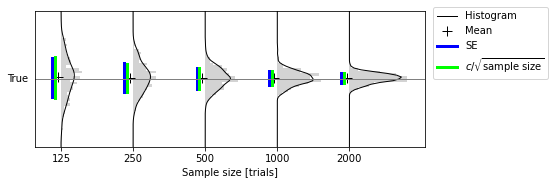

In [423]:
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/'
# num_scenarios = 5
# num_trials = [125, 250, 500, 1000, 2000]
# model_paths = [0] * num_scenarios
# model_paths[0] = model_dir + 'amarasingham_square_alpha1_beta40ms_trials125_kernel120ms_model_par_list.pkl'
# model_paths[1] = model_dir + 'amarasingham_square_alpha1_beta40ms_model_par_list.pkl'
# model_paths[2] = model_dir + 'amarasingham_square_alpha1_beta40ms_trials500_kernel120ms_model_par_list.pkl'
# model_paths[3] = model_dir + 'amarasingham_square_alpha1_beta40ms_trials1000_kernel120ms_model_par_list.pkl'
# model_paths[4] = model_dir + 'amarasingham_square_alpha1_beta40ms_trials2000_kernel120ms_model_par_list.pkl'

# num_scenarios = 5
# num_trials = [125, 250, 500, 1000, 2000]
# model_paths = [0] * num_scenarios
# model_paths[0] = model_dir + 'amarasingham_square_alphaN1_beta40ms_trials125_kernel120ms_model_par_list.pkl'
# model_paths[1] = model_dir + 'amarasingham_square_alphaN1_beta40ms_model_par_list.pkl'
# model_paths[2] = model_dir + 'amarasingham_square_alphaN1_beta40ms_trials500_kernel120ms_model_par_list.pkl'
# model_paths[3] = model_dir + 'amarasingham_square_alphaN1_beta40ms_trials1000_kernel120ms_model_par_list.pkl'
# model_paths[4] = model_dir + 'amarasingham_square_alphaN1_beta40ms_trials2000_kernel120ms_model_par_list.pkl'

# num_scenarios = 5
# num_trials = [125, 250, 500, 1000, 2000]
# model_paths = [0] * num_scenarios
# model_paths[0] = model_dir + 'amarasingham_square_alpha1_beta40ms_trials125_nonrepeated_kernel120ms_model_par_list.pkl'
# model_paths[1] = model_dir + 'amarasingham_square_alpha1_beta40ms_trials250_nonrepeated_kernel120ms_model_par_list.pkl'
# model_paths[2] = model_dir + 'amarasingham_square_alpha1_beta40ms_trials500_nonrepeated_kernel120ms_model_par_list.pkl'
# model_paths[3] = model_dir + 'amarasingham_square_alpha1_beta40ms_trials1000_nonrepeated_kernel120ms_model_par_list.pkl'
# model_paths[4] = model_dir + 'amarasingham_square_alpha1_beta40ms_trials2000_nonrepeated_kernel120ms_model_par_list.pkl'

num_scenarios = 5
num_trials = [125, 250, 500, 1000, 2000]
model_paths = [0] * num_scenarios
model_paths[0] = model_dir + 'amarasingham_square_alphaN1_beta40ms_trials125_nonrepeated_kernel120ms_model_par_list.pkl'
model_paths[1] = model_dir + 'amarasingham_square_alphaN1_beta40ms_trials250_nonrepeated_kernel120ms_model_par_list.pkl'
model_paths[2] = model_dir + 'amarasingham_square_alphaN1_beta40ms_trials500_nonrepeated_kernel120ms_model_par_list.pkl'
model_paths[3] = model_dir + 'amarasingham_square_alphaN1_beta40ms_trials1000_nonrepeated_kernel120ms_model_par_list.pkl'
model_paths[4] = model_dir + 'amarasingham_square_alphaN1_beta40ms_trials2000_nonrepeated_kernel120ms_model_par_list.pkl'

file_path = project_dir + 'Output/fig/estimator_asymptotic_nonrepeated_hN1.pdf'
jittertool.plot_filter_estimator_asymptotic(-1, model_paths, num_trials, file_path=file_path)

#### Theoretical RMSE+likelihood comparison.

In [6]:
jittertool = jitter.JitterTool()
true_par = {'loss': 'L2', 'filter_type': 'square', 'filter_length': 0.03,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1,
            'baseline': 10, 'rho': 30, 'mu': 30, 'background_window': 'gaussian', 'background_window_sigma': 0.1}
jittertool.bias_theoretical(true_par)

(-0.19090639319728855, -33.28681779082939, 174.36198564827404)

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_tune_sigma_I.pdf


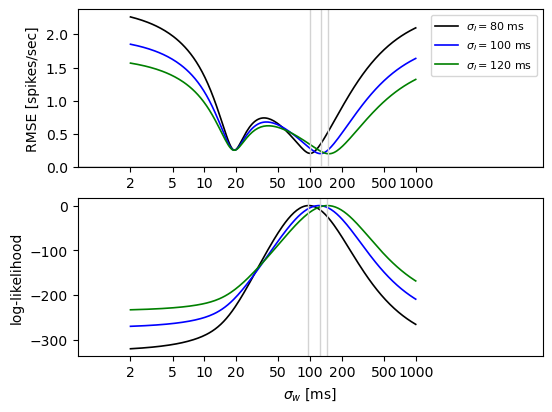

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_tune_sigma_h.pdf


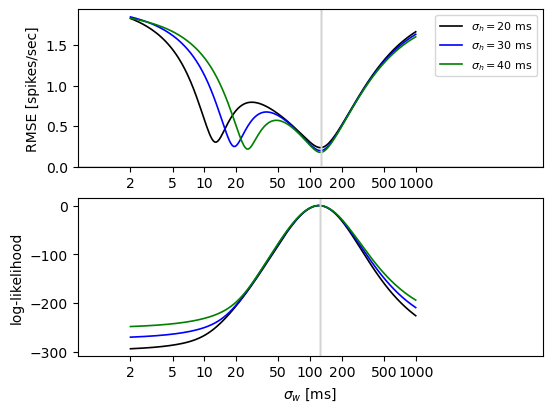

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_tune_alpha_h.pdf


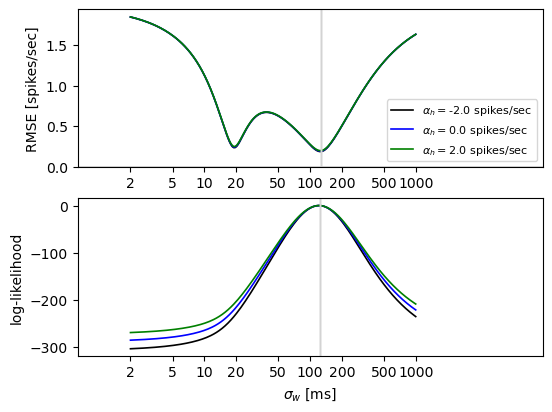

In [13]:
# experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_trials200_nonrepeated_'
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_'

data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
file_path = data_dir + f'{experiment_name}generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)

true_par = {'loss': 'L2', 'filter_type': 'square', 'filter_length': 0.03,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': 10, 'mu': 30, 'rho': 30, 'background_window': 'gaussian', 'background_window_sigma': 0.1,
            'trial_length': generator_par['trial_length'], 'num_trials': generator_par['num_trials'], 
            'alpha': generator_par['alpha'], 'beta': generator_par['beta']}

output_dir = project_dir + 'Output/fig/'

sigma_Is=[0.08,0.1,0.12]
sigma_hs=[0.02,0.03,0.04]
alpha_hs=[-2,0,2]
# jittertool.plot_bias_theoretical(true_par, file_path=None)
jittertool.plot_rmse_likelihood_theoretical(true_par, sigma_Is, sigma_hs, alpha_hs, experiment_name=experiment_name, output_dir=output_dir)

#### bias, risk, likelihood

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bias_rmse_likeli_tune_sigma_I.pdf


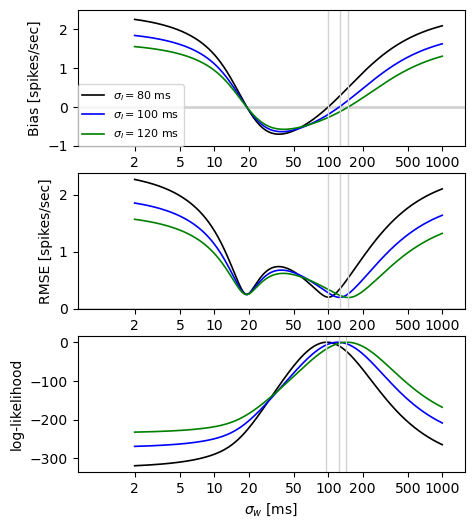

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bias_rmse_likeli_tune_sigma_h.pdf


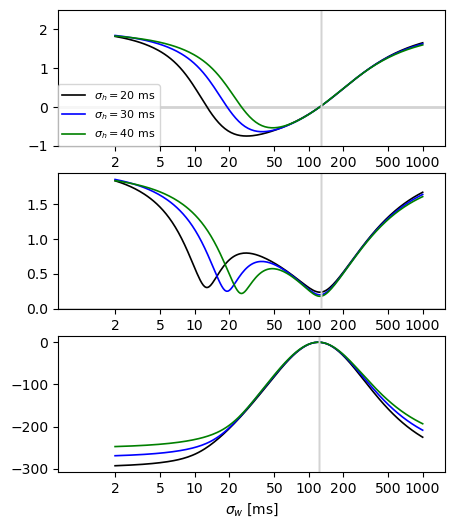

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bias_rmse_likeli_tune_alpha_h.pdf


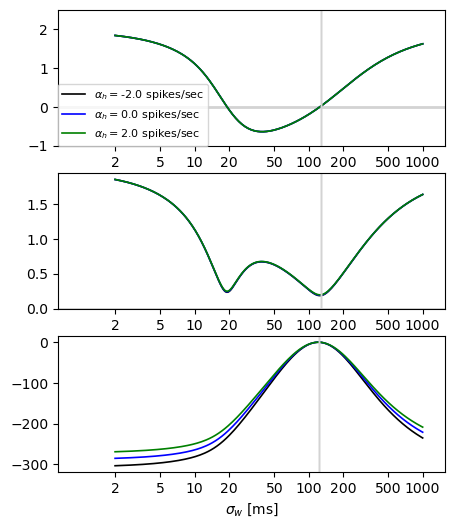

In [68]:
# experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_trials200_nonrepeated_'
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_'

data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
file_path = data_dir + f'{experiment_name}generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)

true_par = {'loss': 'L2', 'filter_type': 'square', 'filter_length': 0.03,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': 10, 'mu': 30, 'rho': 30, 'background_window': 'gaussian', 'background_window_sigma': 0.1,
            'trial_length': generator_par['trial_length'], 'num_trials': generator_par['num_trials'], 
            'alpha': generator_par['alpha'], 'beta': generator_par['beta']}

output_dir = project_dir + 'Output/fig/'

sigma_Is=[0.08,0.1,0.12]
sigma_hs=[0.02,0.03,0.04]
alpha_hs=[-2,0,2]
jittertool.plot_bias_rmse_likelihood_theoretical(true_par, sigma_Is, sigma_hs, alpha_hs, experiment_name=experiment_name, output_dir=output_dir)

#### Theoretical bias comparison.

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bias_tune_sigma_I.pdf


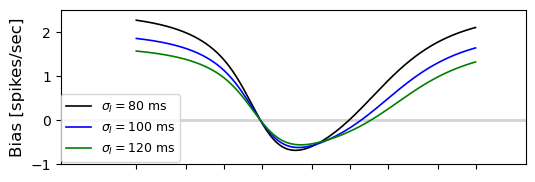

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bias_tune_sigma_h.pdf


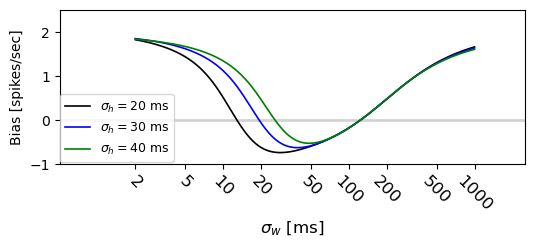

In [56]:
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_'

data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
file_path = data_dir + f'{experiment_name}generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)

true_par = {'loss': 'L2', 'filter_type': 'square', 'filter_length': 0.03,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': 10, 'mu': 30, 'rho': 30, 'background_window': 'gaussian', 'background_window_sigma': 0.1,
            'trial_length': generator_par['trial_length'], 'num_trials': generator_par['num_trials'], 
            'alpha': generator_par['alpha'], 'beta': generator_par['beta']}

output_dir = project_dir + 'Output/fig/'

sigma_Is=[0.08,0.1,0.12]
sigma_hs=[0.02,0.03,0.04]
alpha_hs=[-2,0,2]
# jittertool.plot_bias_theoretical(true_par, file_path=None)
jittertool.plot_multiple_bias_theoretical(true_par, sigma_Is, sigma_hs, alpha_hs, experiment_name=experiment_name, output_dir=output_dir)



#### Basic

theoretical roots: [0.01922855 0.12495191] 	nadir: 0.03906456874469359
num simulation models 100
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_bias.pdf


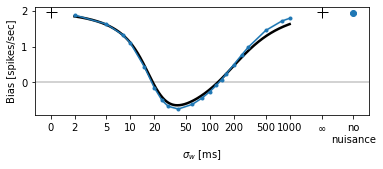

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_var.pdf


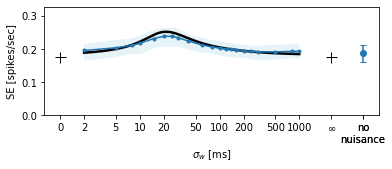

min_rmse_kernel_width: 0.1253409739683807
sim RMSE optimal sigma_w 0.14
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_rmse.pdf


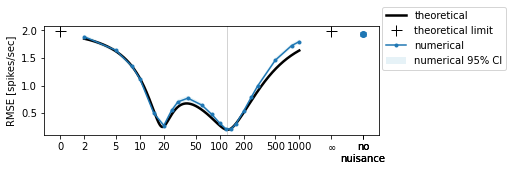

num simulation models 100
max_ll_kernel_width: 0.12137613437594817
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_log_likelihood.pdf


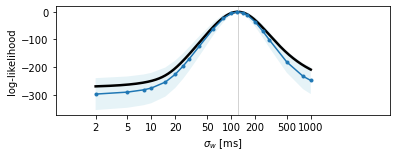

In [1198]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
Sxx_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_bases_inner_prod/'
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_'
# experiment_name = 'poisson_background_gaussian_mixture_square_alphaN2_beta30ms_sigma100ms_trials200_nonrepeated_'
# experiment_name = 'poisson_background_gaussian_mixture_square_alpha0_beta30ms_sigma100ms_trials200_nonrepeated_'
# experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta20ms_sigma100ms_trials200_nonrepeated_'
# experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta40ms_sigma100ms_trials200_nonrepeated_'
# experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma20ms_trials200_nonrepeated_'

# experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma5ms_trials200_nonrepeated_'
# kernel_widths = [2, 5, 6, 8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 140, 160, 200, 250, 300, 500, 800, 1000, 'none']

file_path = data_dir + f'{experiment_name}generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
filter_true_val = generator_par['alpha'][0][1]
filter_length = generator_par['beta'][0][1]
kernel_widths = [2, 5,  8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 140, 160, 200, 250, 300, 500, 800, 1000, 'none']
model_paths = [0] * len(kernel_widths)
Sxx_paths = [0] * len(kernel_widths)

for i, width in enumerate(kernel_widths):
    model_paths[i] = model_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'
for i, width in enumerate(kernel_widths):
    Sxx_paths[i] = Sxx_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'

true_par = {'loss': 'none', 'filter_type': 'square', 'filter_length': filter_length,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': 10, 'mu': 30, 'rho': 30, 'background_window': 'gaussian', 
            'background_window_sigma': 0.1, 'trial_length': generator_par['trial_length'], 
            'num_trials': generator_par['num_trials'], 'alpha': generator_par['alpha'], 'beta': generator_par['beta']}

experiment_name = f'{experiment_name}likelihood_loss_theoretical_numerical_'
output_dir = project_dir + 'Output/fig/'
jittertool.plot_square_filter_beta_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=True,
        experiment_name=experiment_name, output_dir=output_dir)
jittertool.plot_likelihood_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=True,
        aligned_by='max', experiment_name=experiment_name, output_dir=output_dir, verbose=False)


#### Double coupling

theoretical roots: [0.01922855 0.12495191] 	nadir: 0.03906456874469359
num simulation models 100
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_Source2Target_alpha2_beta30ms_Target2Source_alpha01_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_bias.pdf


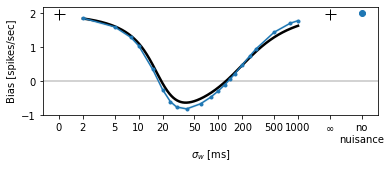

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_Source2Target_alpha2_beta30ms_Target2Source_alpha01_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_var.pdf


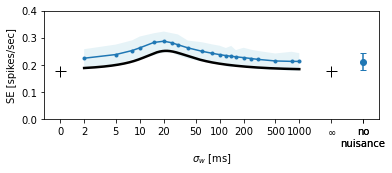

min_rmse_kernel_width: 0.1253409739683807
sim RMSE optimal sigma_w 0.14
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_Source2Target_alpha2_beta30ms_Target2Source_alpha01_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_rmse.pdf


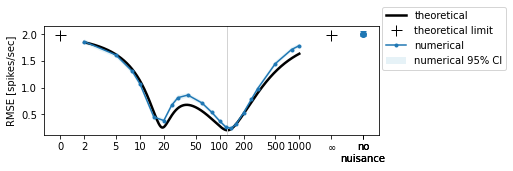

num simulation models 100
max_ll_kernel_width: 0.12137613437594817
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_Source2Target_alpha2_beta30ms_Target2Source_alpha01_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_log_likelihood.pdf


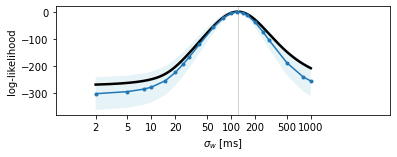

In [22]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
# experiment_name = 'poisson_background_gaussian_mixture_square_Source2Target_Target2Source_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_'
experiment_name = 'poisson_background_gaussian_mixture_square_Source2Target_alpha2_beta30ms_Target2Source_alpha01_sigma100ms_trials200_nonrepeated_'

# experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma5ms_trials200_nonrepeated_'
# kernel_widths = [2, 5, 6, 8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 140, 160, 200, 250, 300, 500, 800, 1000, 'none']

file_path = data_dir + f'{experiment_name}generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
filter_true_val = generator_par['alpha'][0][1]
filter_length = generator_par['beta'][0][1]
kernel_widths = [2, 5,  8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 140, 160, 200, 250, 300, 500, 800, 1000, 'none']
model_paths = [0] * len(kernel_widths)

for i, width in enumerate(kernel_widths):
    model_paths[i] = model_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'

true_par = {'loss': 'none', 'filter_type': 'square', 'filter_length': filter_length,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': 10, 'mu': 30, 'rho': 30, 'background_window': 'gaussian', 
            'background_window_sigma': 0.1, 'trial_length': generator_par['trial_length'], 
            'num_trials': generator_par['num_trials'], 'alpha': generator_par['alpha'], 'beta': generator_par['beta']}

experiment_name = f'{experiment_name}likelihood_loss_theoretical_numerical_'
output_dir = project_dir + 'Output/fig/'
jittertool.plot_square_filter_beta_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=True,
        experiment_name=experiment_name, output_dir=output_dir)
jittertool.plot_likelihood_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=True,
        aligned_by='max', experiment_name=experiment_name, output_dir=output_dir, verbose=False)


#### Full model.

Hawkes

In [73]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
experiment_name = 'poisson_background_gaussian_mixture_square_full_model_beta30ms_sigma100ms_trials200_nonrepeated_'
file_path = data_dir + f'{experiment_name}generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
filter_true_val = generator_par['alpha'][0][1]
filter_length = generator_par['beta'][0][1]
num_itrs = 100

# Hawkes model. x-->y
file_path = model_dir + f'{experiment_name}hawkes_x2y_model_par_list.pkl'
model_par_hat = util.load_variable(file_path, verbose=False)
print('Hawkes', len(model_par_hat), len(model_par_hat)==num_itrs)
true_alpha_x2y = np.array(generator_par['alpha'])[[0,1],1]  # [src->tgt, src->src]

hawkes_alpha_x2y_hat = np.zeros([num_itrs,2])
for itr in range(num_itrs):
    beta_hat = model_par_hat[itr]['beta'][[1,2],0]  # [baseline, cross-coupling, self-coupling]
    hawkes_alpha_x2y_hat[itr] = beta_hat


# Hawkes model. y-->x
file_path = model_dir + f'{experiment_name}hawkes_y2x_model_par_list.pkl'  
model_par_hat = util.load_variable(file_path, verbose=False)
print('Hawkes', len(model_par_hat), len(model_par_hat)==num_itrs)
true_alpha_y2x = np.array(generator_par['alpha'])[[1,0],0]  # [tgt->tgt, tgt->src], so flip.

hawkes_alpha_y2x_hat = np.zeros([num_itrs,2])
for itr in range(num_itrs):
    beta_hat = model_par_hat[itr]['beta'][[1,2],0]  # [baseline, cross-coupling, self-coupling]
    hawkes_alpha_y2x_hat[itr] = beta_hat

err_x2y = hawkes_alpha_x2y_hat - true_alpha_x2y
err_y2x = hawkes_alpha_y2x_hat - true_alpha_y2x

print('--------- bias ---------')
print(err_x2y.mean(axis=0), err_x2y.std(axis=0), err_y2x.mean(axis=0), err_y2x.std(axis=0))

print('--------- abs ---------')
print(np.abs(err_x2y).mean(axis=0), np.abs(err_x2y).std(axis=0), np.abs(err_y2x).mean(axis=0), np.abs(err_y2x).std(axis=0))


Hawkes 100 True
Hawkes 100 True
--------- bias ---------
[1.93949204 1.88972785] [0.20630928 0.18561758] [1.90734012 1.93026503] [0.21510689 0.18618477]
--------- abs ---------
[1.93949204 1.88972785] [0.20630928 0.18561758] [1.90734012 1.93026503] [0.21510689 0.18618477]


jitter regression

In [92]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
experiment_name = 'poisson_background_gaussian_mixture_square_full_model_beta30ms_sigma100ms_trials200_nonrepeated_'
file_path = data_dir + f'{experiment_name}generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
filter_true_val = generator_par['alpha'][0][1]
filter_length = generator_par['beta'][0][1]
num_itrs = 100

# Hawkes model. x-->y
file_path = model_dir + f'{experiment_name}x2y_model_par_list.pkl'
model_par_hat = util.load_variable(file_path, verbose=False)
print('Our model', len(model_par_hat), len(model_par_hat)==num_itrs)
true_alpha_x2y = np.array(generator_par['alpha'])[[0,1],1]  # [src->tgt, src->src]

hawkes_alpha_x2y_hat = np.zeros([num_itrs,2])
kernel_width_x2y = np.zeros(num_itrs)
for itr in range(num_itrs):
    beta_hat = model_par_hat[itr]['beta'][[2,3],0]  # [baseline, cross-coupling, self-coupling]
    hawkes_alpha_x2y_hat[itr] = beta_hat
    kernel_width_x2y[itr] = model_par_hat[itr]['kernel_width']

# Hawkes model. y-->x
file_path = model_dir + f'{experiment_name}y2x_model_par_list.pkl'  
model_par_hat = util.load_variable(file_path, verbose=False)
print('Our model', len(model_par_hat), len(model_par_hat)==num_itrs)
true_alpha_y2x = np.array(generator_par['alpha'])[[1,0],0]  # [tgt->tgt, tgt->src], so flip.

hawkes_alpha_y2x_hat = np.zeros([num_itrs,2])

for itr in range(num_itrs):
    beta_hat = model_par_hat[itr]['beta'][[2,3],0]  # [baseline, cross-coupling, self-coupling]
    hawkes_alpha_y2x_hat[itr] = beta_hat
    
err_x2y = hawkes_alpha_x2y_hat - true_alpha_x2y
err_y2x = hawkes_alpha_y2x_hat - true_alpha_y2x

print('--------- bias ---------')
print(err_x2y.mean(axis=0), err_x2y.std(axis=0), err_y2x.mean(axis=0), err_y2x.std(axis=0))

print('--------- abs ---------')
print(np.abs(err_x2y).mean(axis=0), np.abs(err_x2y).std(axis=0), np.abs(err_y2x).mean(axis=0), np.abs(err_y2x).std(axis=0))


Our model 100 True
Our model 100 True
--------- bias ---------
[-0.5573817  1.2062875] [0.26224317 0.17472109] [0.37030322 1.45881586] [0.21579029 0.19292671]
--------- abs ---------
[0.56156034 1.2062875 ] [0.25317153 0.17472109] [0.37723776 1.45881586] [0.20342467 0.19292671]


#### For fast changing background.

Analytical curves.

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_trials200_nonrepeated_tune_sigma_I.pdf


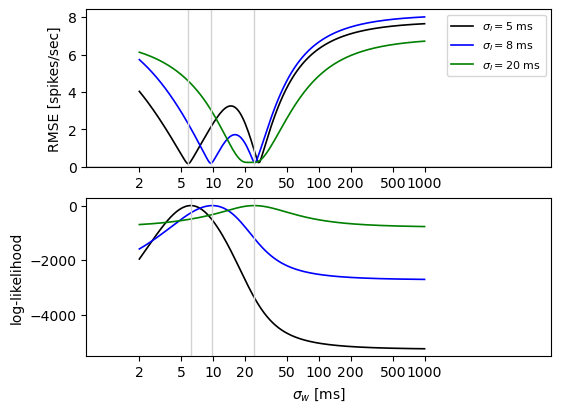

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_trials200_nonrepeated_tune_sigma_h.pdf


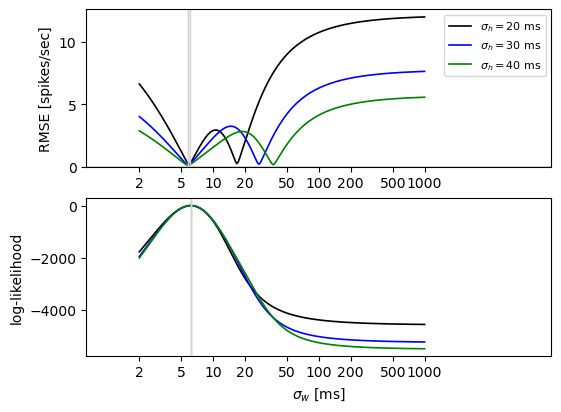

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_trials200_nonrepeated_tune_alpha_h.pdf


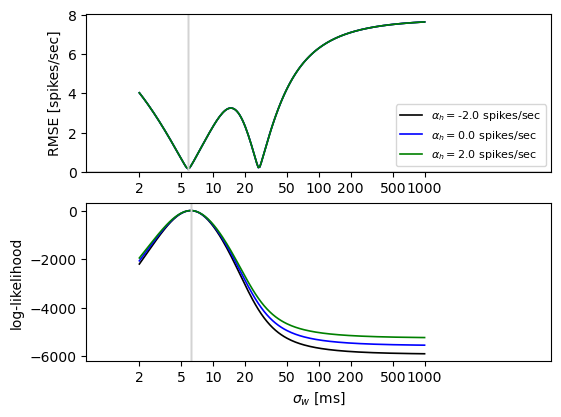

In [80]:
true_par = {'loss': 'L2', 'filter_type': 'square', 'filter_length': 0.03,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': 10, 'mu': 30, 'rho': 30, 'background_window': 'gaussian', 'background_window_sigma': 0.005,
            'trial_length': generator_par['trial_length'], 'num_trials': generator_par['num_trials'], 
            'alpha': generator_par['alpha'], 'beta': generator_par['beta']}
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_trials200_nonrepeated_'
output_dir = project_dir + 'Output/fig/'
sigma_Is=[0.005,0.008,0.02]
sigma_hs=[0.02,0.03,0.04]
alpha_hs=[-2,0,2]
# jittertool.plot_bias_theoretical(true_par, file_path=None)
jittertool.plot_rmse_likelihood_theoretical(true_par, sigma_Is, sigma_hs, alpha_hs, experiment_name=experiment_name, output_dir=output_dir)


save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_trials200_nonrepeated_bias_rmse_likeli_tune_sigma_I.pdf


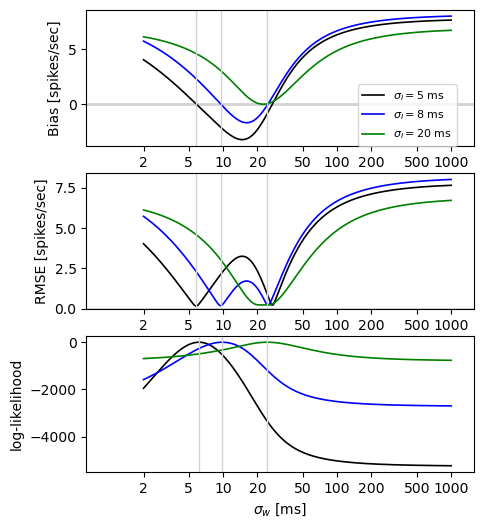

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_trials200_nonrepeated_bias_rmse_likeli_tune_sigma_h.pdf


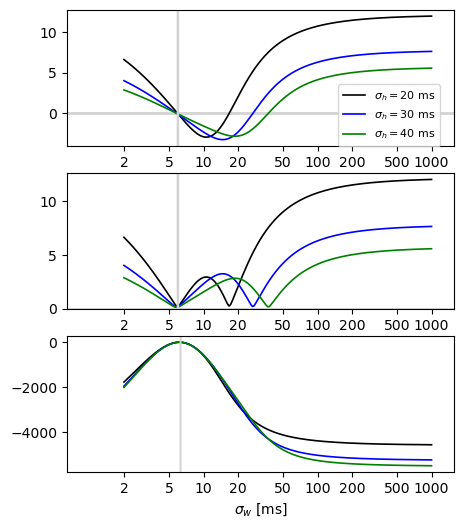

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_trials200_nonrepeated_bias_rmse_likeli_tune_alpha_h.pdf


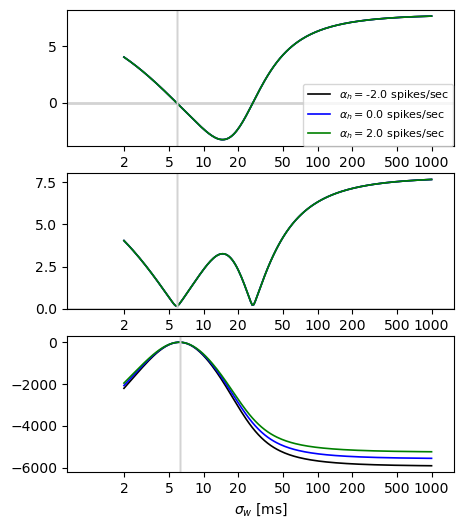

In [88]:
true_par = {'loss': 'L2', 'filter_type': 'square', 'filter_length': 0.03,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': 10, 'mu': 30, 'rho': 30, 'background_window': 'gaussian', 'background_window_sigma': 0.005,
            'trial_length': generator_par['trial_length'], 'num_trials': generator_par['num_trials'], 
            'alpha': generator_par['alpha'], 'beta': generator_par['beta']}
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_trials200_nonrepeated_'
output_dir = project_dir + 'Output/fig/'
sigma_Is=[0.005,0.008,0.02]
sigma_hs=[0.02,0.03,0.04]
alpha_hs=[-2,0,2]
jittertool.plot_bias_rmse_likelihood_theoretical(true_par, sigma_Is, sigma_hs, alpha_hs, experiment_name=experiment_name, output_dir=output_dir)


Numerical results.

theoretical roots: [0.00949424 0.02473486] 	nadir: 0.016055995980021626
num simulation models 100
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma8ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_bias.pdf


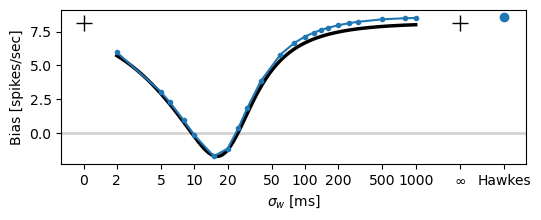

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma8ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_var.pdf


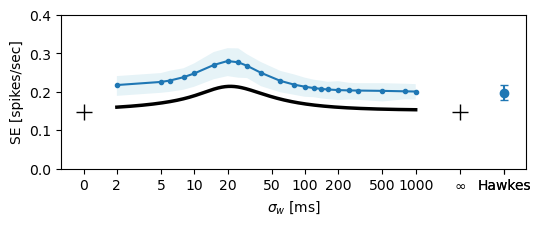

min_rmse_kernel_width: 0.009494239803756757
sim RMSE optimal sigma_w 0.01
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma8ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_rmse.pdf


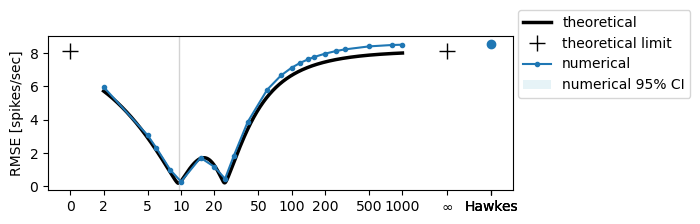

num simulation models 100
max_ll_kernel_width: 0.009832363925410799
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma8ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_log_likelihood.pdf


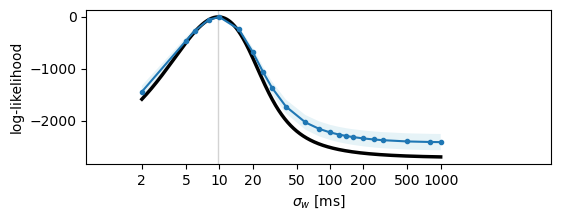

In [126]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
Sxx_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_bases_inner_prod/'
# experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_'
# experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma20ms_trials200_nonrepeated_'
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma8ms_trials200_nonrepeated_'


file_path = data_dir + f'{experiment_name}generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
filter_true_val = generator_par['alpha'][0][1]
filter_length = generator_par['beta'][0][1]
kernel_widths = [2, 5, 6, 8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 140, 160, 200, 250, 300, 500, 800, 1000, 'none']
# kernel_widths = [2, 5,  8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 140, 160, 200, 250, 300, 500, 800, 1000, 'none']
model_paths = [0] * len(kernel_widths)
Sxx_paths = [0] * len(kernel_widths)

for i, width in enumerate(kernel_widths):
    model_paths[i] = model_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'
for i, width in enumerate(kernel_widths):
    Sxx_paths[i] = Sxx_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'

true_par = {'loss': 'none', 'filter_type': 'square', 'filter_length': filter_length,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': 10, 'mu': 30, 'rho': 30, 'background_window': 'gaussian', 
            'background_window_sigma': generator_par['sigma'], 'trial_length': generator_par['trial_length'], 
            'num_trials': generator_par['num_trials'], 'alpha': generator_par['alpha'], 'beta': generator_par['beta']}

experiment_name = f'{experiment_name}likelihood_loss_theoretical_numerical_'
output_dir = project_dir + 'Output/fig/'
jittertool.plot_square_filter_beta_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=True,
        experiment_name=experiment_name, output_dir=output_dir)
jittertool.plot_likelihood_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=True,
        aligned_by='max', experiment_name=experiment_name, output_dir=output_dir, verbose=False)


Generate new data.

In [1661]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
trial_length = 5
trial_window = [0, trial_length]
num_trials = 200
alpha = 0; alpha_str = '0'
beta = 30; beta_str = '30'  # ms
# model_name = 'poisson_background_gaussian_mixture_square_' + \
#         f'alpha{alpha_str}_beta{beta_str}ms_sigma20ms_trials{num_trials}_nonrepeated'
model_name = 'poisson_background_gaussian_mixture_square_' + \
        f'alpha{alpha_str}_beta{beta_str}ms_sigma5ms_trials{num_trials}_nonrepeated'

generator_par = {'num_trials': num_trials, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 30, 'mu': 30, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.005, 'random_seed': None,
    'type': 'square', 'alpha': [[0., alpha], [0.0, 0.0]], 'beta': [[0.0, beta/1000], [0.0, 0.0]], 'num_nodes': 2}
file_path = data_dir + model_name + '_generator_par.pkl'
util.save_variable(file_path, generator_par)

itr = 0
generator_par['random_seed'] = itr
spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=2)
file_path = data_dir + model_name + f'_itr{itr}.pkl'
util.save_variable(file_path, spike_times, verbose=False)
spike_times_x, spike_times_y = spike_times[1], spike_times[0]

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_data/poisson_background_gaussian_mixture_square_alpha0_beta30ms_sigma5ms_trials200_nonrepeated_generator_par.pkl
100%|█████████████████████████████████████████████████████████████| 200/200 [01:12<00:00,  2.76it/s]


Load existing data.

In [1671]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma5ms_trials200_nonrepeated'

file_path = data_dir + f'{model_name}_generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']

itr = 0
file_path = data_dir + f'{model_name}_itr{itr}.pkl'
spike_times = util.load_variable(file_path, verbose=False)
spike_times_x, spike_times_y = spike_times[1], spike_times[0]

In [1662]:
kernel_width = 6
if kernel_width == 'none':
    model_par = {'filter_type': 'square', 'filter_length': generator_par['beta'][0][1],
                 'append_nuisance': ['const'],
                 'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}
else:
    model_par = {'filter_type': 'square', 'filter_length': generator_par['beta'][0][1],
                 'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': kernel_width/1000,
                 'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}

model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
        spike_times_x, spike_times_y, [0,trial_length], model_par)

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha0_beta30ms_sigma5ms_trials200_nonrepeated_regression_kernel6ms.pdf


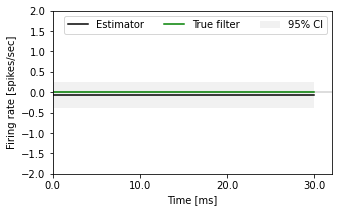

In [1665]:
file_path = project_dir + f'Output/fig/{model_name}_regression_kernel{kernel_width}ms.pdf'
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, generator_par, xlim=[0, 0.032], ylim=[-2,2], file_path=file_path)


100%|███████████████████████████████████████████████████████████| 1000/1000 [01:10<00:00, 14.13it/s]
Save figure to: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma5ms_trials200_nonrepeated_jwindow10ms_bin1ms.pdf


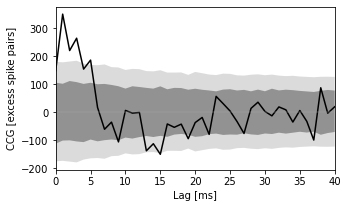

In [1673]:
length = trial_length
spk_bin_width = 0.001
lag_range = [0, 0.04]
jitter_window_width = 0.01
num_jitter = 1000
distribution_type='mc_sim' # poisson, binom, mc_sim

file_path = project_dir + f'Output/fig/{model_name}_jwindow{jitter_window_width*1000:.0f}ms_bin{spk_bin_width*1000:.0f}ms.pdf'
_ = jittertool.cross_correlation_jitter(spike_times_x, spike_times_y, spk_bin_width, length, lag_range, 
    jitter_window_width=jitter_window_width, distribution_type=distribution_type, num_jitter=num_jitter, ci_alpha=0.05, file_path=file_path, verbose=1)

#### varying $\sigma_I$

theoretical roots: [0.01922855 0.12495191] 	nadir: 0.03906456874469359
num simulation models 100
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_varying_sigma_80_140ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_bias.pdf


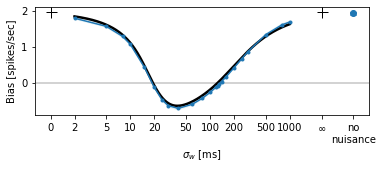

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_varying_sigma_80_140ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_var.pdf


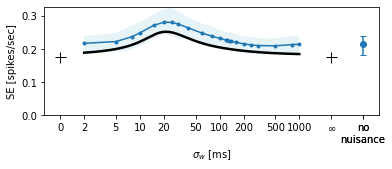

min_rmse_kernel_width: 0.1253409739683807
sim RMSE optimal sigma_w 0.14
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_varying_sigma_80_140ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_rmse.pdf


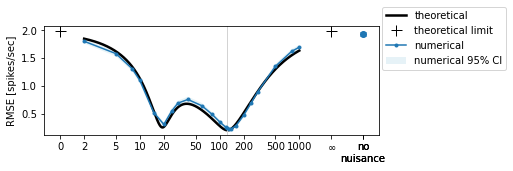

num simulation models 100
max_ll_kernel_width: 0.12137613437594817
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_varying_sigma_80_140ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_log_likelihood.pdf


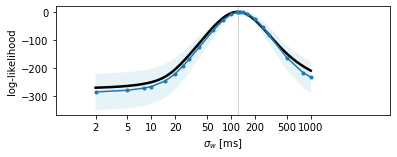

In [1201]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
Sxx_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_bases_inner_prod/'
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_varying_sigma_80_140ms_trials200_nonrepeated_'
file_path = data_dir + f'{experiment_name}generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
filter_true_val = generator_par['alpha'][0][1]
kernel_widths = [2, 5, 8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 125, 130, 140, 160, 200, 250, 300, 500, 800, 1000, 'none']
model_paths = [0] * len(kernel_widths)
Sxx_paths = [0] * len(kernel_widths)

for i, width in enumerate(kernel_widths):
    model_paths[i] = model_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'
for i, width in enumerate(kernel_widths):
    Sxx_paths[i] = Sxx_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'

true_par = {'loss': 'none', 'filter_type': 'square', 'filter_length': 0.03,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': 10, 'mu': 30, 'rho': 30, 'background_window': 'gaussian', 
            'background_window_sigma': 0.1, 'trial_length': generator_par['trial_length'], 
            'num_trials': generator_par['num_trials'], 'alpha': generator_par['alpha'], 'beta': generator_par['beta']}

experiment_name = f'{experiment_name}likelihood_loss_theoretical_numerical_'
output_dir = project_dir + 'Output/fig/'
jittertool.plot_square_filter_beta_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=True,
        experiment_name=experiment_name, output_dir=output_dir)
jittertool.plot_likelihood_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=True,
        aligned_by='max', experiment_name=experiment_name, output_dir=output_dir)


#### With non-shared slow-rate activities.

theoretical roots: [0.01922855 0.12929885] 	nadir: 0.03992400992044709
num simulation models 100
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_sharerho20_nonsharerho10_trials200_nonrepeated_likelihood_loss_theoretical_numerical_bias.pdf


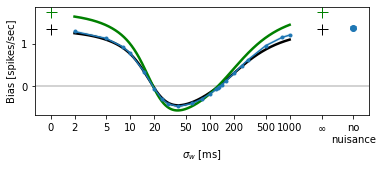

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_sharerho20_nonsharerho10_trials200_nonrepeated_likelihood_loss_theoretical_numerical_var.pdf


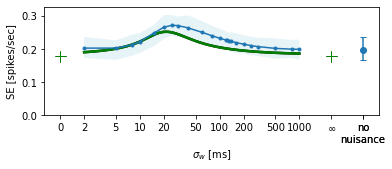

min_rmse_kernel_width: 0.1301052992891182
sim RMSE optimal sigma_w 0.14
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_sharerho20_nonsharerho10_trials200_nonrepeated_likelihood_loss_theoretical_numerical_rmse.pdf


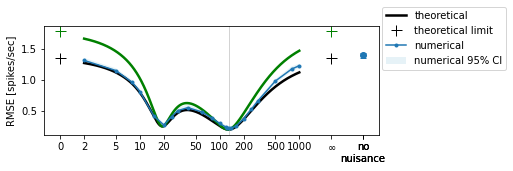

num simulation models 100
max_ll_kernel_width: 0.12677832325000482
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_sharerho20_nonsharerho10_trials200_nonrepeated_likelihood_loss_theoretical_numerical_log_likelihood.pdf


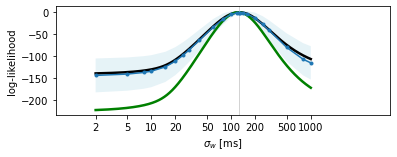

In [1213]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_sharerho20_nonsharerho10_trials200_nonrepeated_'
file_path = data_dir + f'{experiment_name}generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
filter_true_val = generator_par['alpha'][0][1]
kernel_widths = [2, 5, 8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 125, 130, 140, 160, 200, 250, 300, 500, 800, 1000, 'none']
model_paths = [0] * len(kernel_widths)
Sxx_paths = [0] * len(kernel_widths)

for i, width in enumerate(kernel_widths):
    model_paths[i] = model_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'

true_par = {'loss': 'none', 'filter_type': 'square', 'filter_length': 0.03,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': 10, 'mu': 10, 'rho': 10, 'background_window': 'gaussian', 
            'background_window_sigma': 0.1, 'trial_length': generator_par['trial_length'], 
            'num_trials': generator_par['num_trials'], 'alpha': generator_par['alpha'], 'beta': generator_par['beta']}

true_par2 = {'loss': 'none', 'filter_type': 'square', 'filter_length': 0.03,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': 10, 'mu': 20, 'rho': 20, 'background_window': 'gaussian', 
            'background_window_sigma': 0.1, 'trial_length': generator_par['trial_length'], 
            'num_trials': generator_par['num_trials'], 'alpha': generator_par['alpha'], 'beta': generator_par['beta']}

experiment_name = f'{experiment_name}likelihood_loss_theoretical_numerical_'
output_dir = project_dir + 'Output/fig/'
jittertool.plot_square_filter_beta_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=True, par2=true_par2,
        experiment_name=experiment_name, output_dir=output_dir)
jittertool.plot_likelihood_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=True, par2=true_par2,
        aligned_by='max', experiment_name=experiment_name, output_dir=output_dir)


### Inhomoge-injection of non-shared.

theoretical roots: [0.01922855 0.13255495] 	nadir: 0.04054944881320961
num simulation models 100
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_inhomorho_10_0_trials200_nonrepeated_likelihood_loss_theoretical_numerical_bias.pdf


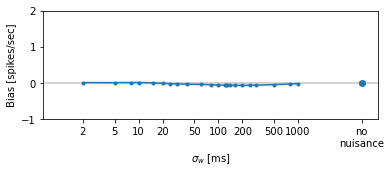

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_inhomorho_10_0_trials200_nonrepeated_likelihood_loss_theoretical_numerical_var.pdf


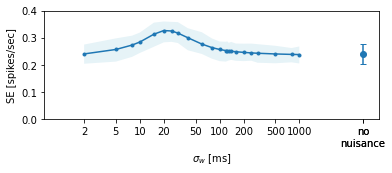

min_rmse_kernel_width: 0.13463151936070122
sim RMSE optimal sigma_w 0.8
empirical max is not shown
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_inhomorho_10_0_trials200_nonrepeated_likelihood_loss_theoretical_numerical_rmse.pdf


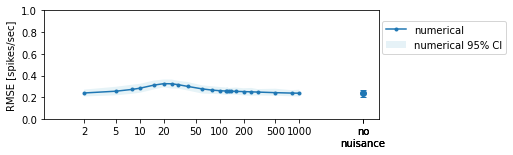

num simulation models 100
max_ll_kernel_width: 0.5
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_inhomorho_10_0_trials200_nonrepeated_likelihood_loss_theoretical_numerical_log_likelihood.pdf


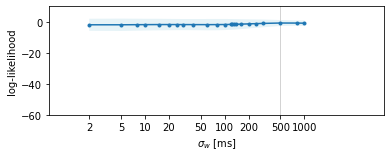

In [65]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_inhomorho_10_0_trials200_nonrepeated_'
file_path = data_dir + f'{experiment_name}generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
filter_true_val = generator_par['alpha'][0][1]
kernel_widths = [2, 5, 8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 125, 130, 140, 160, 200, 250, 300, 500, 800, 1000, 'none']
model_paths = [0] * len(kernel_widths)
Sxx_paths = [0] * len(kernel_widths)

for i, width in enumerate(kernel_widths):
    model_paths[i] = model_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'

true_par = {'loss': 'none', 'filter_type': 'square', 'filter_length': 0.03,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': 20, 'mu': 10, 'rho': 10, 'background_window': 'gaussian', 
            'background_window_sigma': 0.1, 'trial_length': generator_par['trial_length'], 
            'num_trials': generator_par['num_trials'], 'alpha': generator_par['alpha'], 'beta': generator_par['beta']}

experiment_name = f'{experiment_name}likelihood_loss_theoretical_numerical_'
output_dir = project_dir + 'Output/fig/'
jittertool.plot_square_filter_beta_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=False,
        experiment_name=experiment_name, output_dir=output_dir)
jittertool.plot_likelihood_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=False,
        aligned_by='max', experiment_name=experiment_name, output_dir=output_dir)


theoretical roots: [0.01922855 0.13255495] 	nadir: 0.04054944881320961
num simulation models 100
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_inhomorho_target0_source10_trials200_nonrepeated_likelihood_loss_theoretical_numerical_bias.pdf


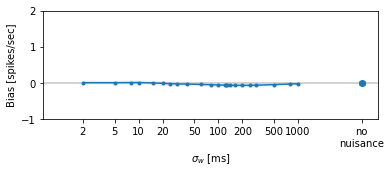

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_inhomorho_target0_source10_trials200_nonrepeated_likelihood_loss_theoretical_numerical_var.pdf


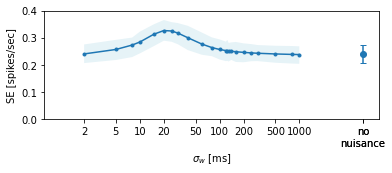

min_rmse_kernel_width: 0.13463151936070122
sim RMSE optimal sigma_w 0.8
empirical max is not shown
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_inhomorho_target0_source10_trials200_nonrepeated_likelihood_loss_theoretical_numerical_rmse.pdf


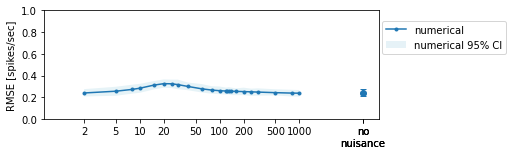

num simulation models 100
max_ll_kernel_width: 0.5
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_inhomorho_target0_source10_trials200_nonrepeated_likelihood_loss_theoretical_numerical_log_likelihood.pdf


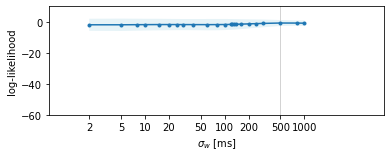

In [66]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_inhomorho_target0_source10_trials200_nonrepeated_'
file_path = data_dir + f'{experiment_name}generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
filter_true_val = generator_par['alpha'][0][1]
kernel_widths = [2, 5, 8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 125, 130, 140, 160, 200, 250, 300, 500, 800, 1000, 'none']
model_paths = [0] * len(kernel_widths)
Sxx_paths = [0] * len(kernel_widths)

for i, width in enumerate(kernel_widths):
    model_paths[i] = model_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'

true_par = {'loss': 'none', 'filter_type': 'square', 'filter_length': 0.03,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': 20, 'mu': 10, 'rho': 10, 'background_window': 'gaussian', 
            'background_window_sigma': 0.1, 'trial_length': generator_par['trial_length'], 
            'num_trials': generator_par['num_trials'], 'alpha': generator_par['alpha'], 'beta': generator_par['beta']}

experiment_name = f'{experiment_name}likelihood_loss_theoretical_numerical_'
output_dir = project_dir + 'Output/fig/'
jittertool.plot_square_filter_beta_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=False,
        experiment_name=experiment_name, output_dir=output_dir)
jittertool.plot_likelihood_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=False,
        aligned_by='max', experiment_name=experiment_name, output_dir=output_dir)


#### Self-coupling

In [1524]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'

# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alphaN2_beta30ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha0_beta30ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_varying_sigma_80_140ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_sharerho20_nonsharerho10_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma20ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma5ms_trials200_nonrepeated'
# model_name = 'poisson_background_laplacian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_self_coupling_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_self_coupling15ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_source_self_coupling15ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_source_selfcouplingN15_10ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_target_selfcouplingN20_20ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_source_selfcouplingN20_20ms_sigma100ms_trials200_nonrepeated'
model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_target_selfcouplingN15_10ms_sigma100ms_trials200_nonrepeated'


file_path = data_dir + f'{model_name}_generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']

num_itrs = 100
# kernel_widths = [2,5,8,10,15,20,25,30,40,60,80,90,100,120,125,130,140,160,180,200,250,300,500,800,1000,'none']
kernel_widths = [180,]

for kernel_width in kernel_widths:
    model_par_list = []
    if kernel_width == 'none':
        model_par = {'filter_type': 'square', 'filter_length': generator_par['beta'][0][1],
                     'append_nuisance': ['const'],
                     'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}
    else:
        model_par = {'filter_type': 'square', 'filter_length': generator_par['beta'][0][1],
                     'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': kernel_width/1000,
                     'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}

    trange = tqdm(range(num_itrs), ncols=100, file=sys.stdout)
    for itr in trange:
        file_path = data_dir + f'{model_name}_itr{itr}.pkl'
        spike_times = util.load_variable(file_path, verbose=False)
        spike_times_x, spike_times_y = spike_times[1], spike_times[0]
        model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
                spike_times_x, spike_times_y, [0,trial_length], model_par)
        model_par_list.append(model_par_hat)

    file_path = model_dir + f'{model_name}_kernel{kernel_width}ms_model_par_list.pkl'
    util.save_variable(file_path, model_par_list)

100%|█████████████████████████████████████████████████████████████| 100/100 [11:53<00:00,  7.13s/it]
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/poisson_background_gaussian_mixture_square_alpha2_beta30ms_target_selfcouplingN15_10ms_sigma100ms_trials200_nonrepeated_kernel180ms_model_par_list.pkl


theoretical roots: [0.01922855 0.12929885] 	nadir: 0.03992400992044709
num simulation models 100
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_source_selfcouplingN20_20ms_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_bias.pdf


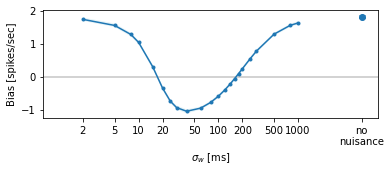

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_source_selfcouplingN20_20ms_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_var.pdf


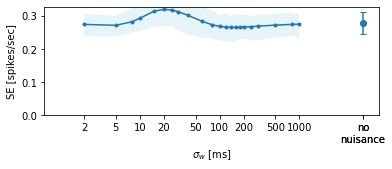

min_rmse_kernel_width: 0.1301052992891182
sim RMSE optimal sigma_w 0.16
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_source_selfcouplingN20_20ms_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_rmse.pdf


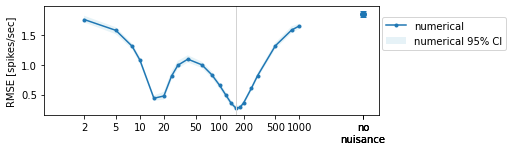

num simulation models 100
max_ll_kernel_width: 0.12
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_source_selfcouplingN20_20ms_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_log_likelihood.pdf


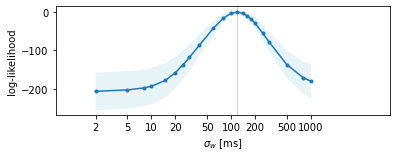

In [1613]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'

# target N25_30ms rho30 baseline10
# experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_self_coupling_sigma100ms_trials200_nonrepeated_'
# target N25_15ms rho30 baseline10
# experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_self_coupling15ms_sigma100ms_trials200_nonrepeated_'
# source N25_15ms rho30 baseline10
# experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_source_self_coupling15ms_sigma100ms_trials200_nonrepeated_'
# experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_source_selfcouplingN15_10ms_sigma100ms_trials200_nonrepeated_'
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_source_selfcouplingN20_20ms_sigma100ms_trials200_nonrepeated_'
# experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_target_selfcouplingN20_20ms_sigma100ms_trials200_nonrepeated_'
# experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_target_selfcouplingN15_10ms_sigma100ms_trials200_nonrepeated_'
# kernel_widths = [2, 5, 8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 140, 160, 170, 180, 200, 250, 300, 500, 800, 1000, 'none']
# experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_selfcoupling_sourceN15_10ms_targetN15_10ms_sigma100ms_trials200_nonrepeated_'
# experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_selfcoupling_sourceN15_10ms_targetN20_20ms_sigma100ms_trials200_nonrepeated_'


file_path = data_dir + f'{experiment_name}generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
filter_true_val = generator_par['alpha'][0][1]
filter_length = generator_par['beta'][0][1]
kernel_widths = [2, 5, 8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 140, 160, 180, 200, 250, 300, 500, 800, 1000, 'none']
model_paths = [0] * len(kernel_widths)

for i, width in enumerate(kernel_widths):
    model_paths[i] = model_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'

true_par = {'loss': 'none', 'filter_type': 'square', 'filter_length': filter_length,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': generator_par['baseline'], 'mu': generator_par['mu'], 'rho': generator_par['rho'], 
            'background_window': 'gaussian', 'background_window_sigma': 0.1, 'trial_length': generator_par['trial_length'], 
            'num_trials': generator_par['num_trials'], 'alpha': generator_par['alpha'], 'beta': generator_par['beta']}

experiment_name = f'{experiment_name}likelihood_loss_theoretical_numerical_'
output_dir = project_dir + 'Output/fig/'
jittertool.plot_square_filter_beta_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=False,
        experiment_name=experiment_name, output_dir=output_dir)
jittertool.plot_likelihood_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=False,
        aligned_by='max', experiment_name=experiment_name, output_dir=output_dir, verbose=False)


Replicate KS test error using self-coupling.

In [129]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
num_trials = 200
alpha = 2; alpha_str = '2'
beta = 30; beta_str = '30'  # ms
##### Source self-coupling.
# generator_par = {'num_trials': num_trials, 'trial_length': trial_length, 'trial_window': trial_window,
#     'rho': 20, 'mu': 20, 'baseline': 20, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': None,
#     'type': 'square', 'alpha': [[-0, alpha], [0.0, -20.0]], 'beta': [[0.0, beta/1000], [0.0, 0.02]], 'num_nodes': 2}
##### Target self-coupling.
# generator_par = {'num_trials': num_trials, 'trial_length': trial_length, 'trial_window': trial_window,
#     'rho': 20, 'mu': 20, 'baseline': 20, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': None,
#     'type': 'square', 'alpha': [[-20.0, alpha], [0.0, 0.0]], 'beta': [[0.02, beta/1000], [0.0, 0.0]], 'num_nodes': 2}
##### Source-Target self-coupling.
generator_par = {'num_trials': num_trials, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 20, 'mu': 20, 'baseline': 20, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': None,
    'type': 'square', 'alpha': [[-20.0, alpha], [0.0, -15.0]], 'beta': [[0.02, beta/1000], [0.0, 0.01]], 'num_nodes': 2}

spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=2)
spike_times_x, spike_times_y = spike_times[1], spike_times[0]

100%|█████████████████████████████████████████████████████████████| 200/200 [00:22<00:00,  9.03it/s]


layers 2, nodes 1, trials 200
meanFR 42.294	meanISI 42.7


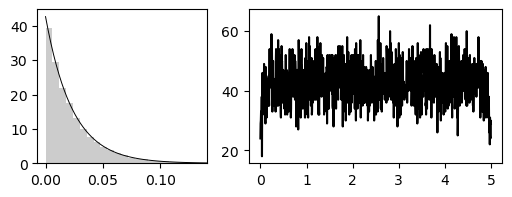

In [130]:
jittertool = jitter.JitterTool()
generator = hierarchical_model_generator.HierarchicalModelGenerator()

data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_self_coupling_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_self_coupling15ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_source_self_coupling15ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_source_selfcouplingN15_10ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_target_selfcouplingN20_20ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_target_selfcouplingN15_10ms_sigma100ms_trials200_nonrepeated'
# model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_target_selfcouplingN15_10ms_sigma100ms_trials200_nonrepeated'

file_path = data_dir + f'{model_name}_generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
file_path = data_dir + f'{model_name}_itr{2}.pkl'
spike_times = util.load_variable(file_path, verbose=False)
spike_times_x, spike_times_y = spike_times[1], spike_times[0]
generator.spike_times_statistics(spike_times_y, generator_par['trial_length'], verbose=1)

100%|███████████████████████████████████████████████████████████████| 32/32 [00:18<00:00,  1.71it/s]
optimal kernel width  120.0


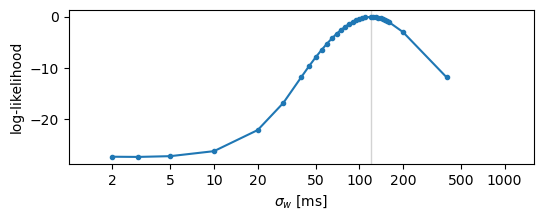

In [151]:
model_par = {'trial_window': [0, trial_length], 'append_nuisance': ['const', 'gaussian_kernel']}
_=jittertool.estimate_optimal_jitter_window_width_regression(spike_times_x[:20], spike_times_y[:20], model_par)

100%|███████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.19it/s]
optimal kernel width  120.0


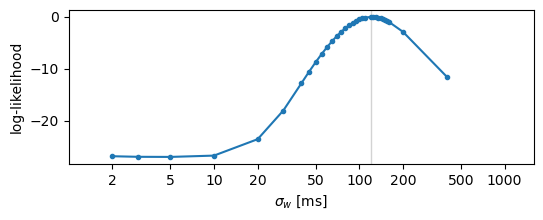

In [140]:
model_par = {'dt': 0.001, 'trial_window': [0, trial_length], 'append_nuisance': ['const', 'gaussian_kernel']}
_=jittertool.estimate_optimal_jitter_window_width(spike_times_x[:20], spike_times_y[:20], model_par)

optimal kernel width  95.0


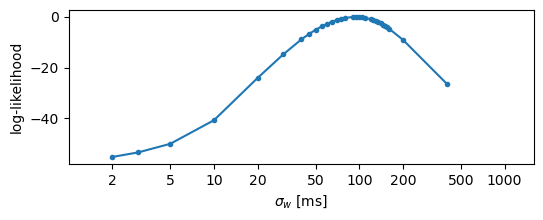

In [141]:
model_par = {'dt': 0.001, 'trial_window': [0, trial_length], 'append_nuisance': ['const', 'gaussian_kernel']}
_=jittertool.estimate_optimal_jitter_window_width_simple(spike_times_x[:20], spike_times_y[:20], model_par)

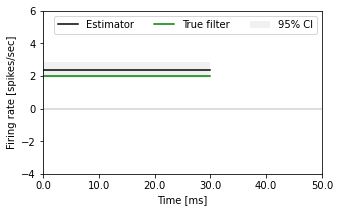

In [1575]:
model_par = {'filter_type': 'square', 'filter_length': generator_par['beta'][0][1],
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.12,
             'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}
# model_par = {'filter_type': 'bspline', 'num_knots': 5, 'knot_space_par': 0.1, 'filter_length': 0.05, 'num_tail_drop': 1,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.12,
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
        spike_times_x, spike_times_y, [0,trial_length], model_par)
file_path = project_dir + f'Output/fig/{model_name}_regression_kernel{kernel_width}ms.pdf'
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, generator_par, ylim=[-4,6], file_path=None)

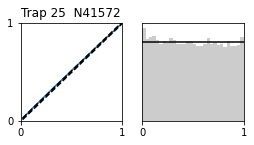

In [1578]:
u_list = jittertool.ks_test(spike_times_x[:], spike_times_y[:], [0,trial_length], model_par_hat, dt=0.0002, test_size=0.01, verbose=True)


Save figure to: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_source_selfcouplingN15_10ms_sigma100ms_trials200_nonrepeated_ks_test.pdf


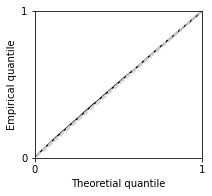

In [1579]:
figure_path = project_dir + f'Output/fig/{model_name}_ks_test.pdf'
_=jittertool.check_ks(u_list, test_size=0.05, bin_width=0.01, figure_path=figure_path)

#### Unmatch filter length fitting.

theoretical roots: [0.01279604 0.12495191] 	nadir: 0.028537561863061854
num simulation models 100
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_fitbeta_20ms_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_bias.pdf


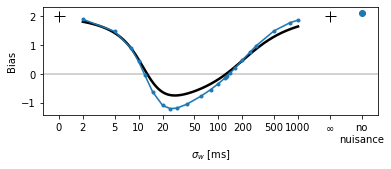

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_fitbeta_20ms_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_var.pdf


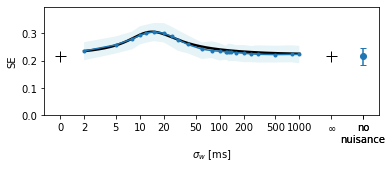

min_rmse_kernel_width: 0.1253409739683807
sim RMSE optimal sigma_w 0.14
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_fitbeta_20ms_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_rmse.pdf


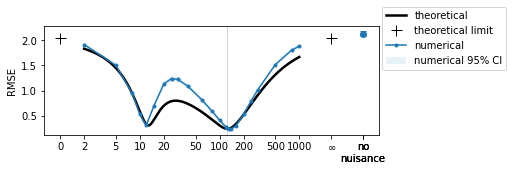

num simulation models 100
max_ll_kernel_width: 0.12137613437594817
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_fitbeta_20ms_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_log_likelihood.pdf


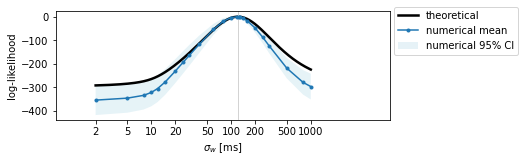

In [765]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
generator_path = data_dir + 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_generator_par.pkl'
generator_par = util.load_variable(generator_path, verbose=False)
trial_length = generator_par['trial_length']
filter_true_val = generator_par['alpha'][0][1]
kernel_widths = [2, 5, 8, 10, 12, 15, 20, 25, 30, 40, 60, 80, 100, 120, 125, 130, 140, 160, 200, 250, 300, 500, 800, 1000, 'none']
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_fitbeta_20ms_sigma100ms_trials200_nonrepeated_'
filter_length = 0.02
# kernel_widths = [2,5,8,10,12,15,18,20,25,30,40,60,80,100,120,125,130,140,160,180,200,250,300,500,800,1000,'none']
# experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_fitbeta_40ms_sigma100ms_trials200_nonrepeated_'
# filter_length = 0.04

model_paths = [0] * len(kernel_widths)
for i, width in enumerate(kernel_widths):
    model_paths[i] = model_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'
true_par = {'loss': 'none', 'filter_type': 'square', 'filter_length': filter_length,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': 10, 'mu': 30, 'rho': 30, 'background_window': 'gaussian', 
            'background_window_sigma': 0.1, 'trial_length': generator_par['trial_length'], 
            'num_trials': generator_par['num_trials'], 'alpha': generator_par['alpha'], 'beta': generator_par['beta']}
experiment_name = f'{experiment_name}likelihood_loss_theoretical_numerical_'
output_dir = project_dir + 'Output/fig/'
jittertool.plot_square_filter_beta_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=True,
        experiment_name=experiment_name, output_dir=output_dir)
jittertool.plot_likelihood_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=True,
        aligned_by='max', experiment_name=experiment_name, output_dir=output_dir)


#### Non-parametric  fitting

num simulation models 100
min_rmise_kernel_width: 0.14
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_rmise.pdf


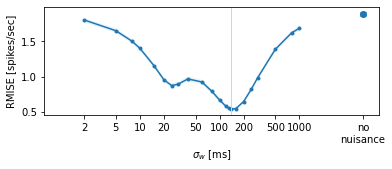

num simulation models 100
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_bias.pdf


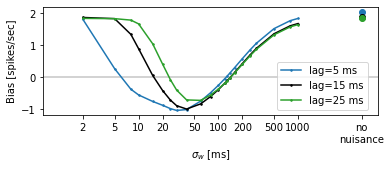

num simulation models 100
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_SE.pdf


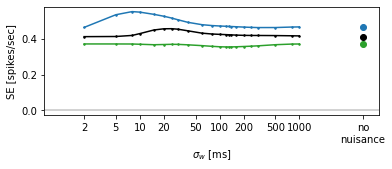

num simulation models 100
max_ll_kernel_width: 0.12
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_log_likelihood.pdf


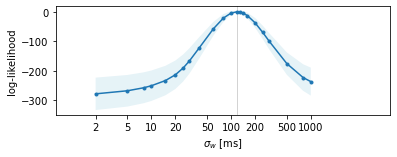

In [1234]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
generator_path = data_dir + 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_generator_par.pkl'
generator_par = util.load_variable(generator_path, verbose=False)
kernel_widths = [2, 5, 8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 130, 140, 160, 200, 250, 300, 500, 800, 1000, 'none']
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_'

model_paths = [0] * len(kernel_widths)
for i, width in enumerate(kernel_widths):
    model_paths[i] = model_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'
true_par = {'loss': 'none', 'filter_type': 'square', 'filter_length': filter_length,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': 10, 'mu': 30, 'rho': 30, 'background_window': 'gaussian', 
            'background_window_sigma': 0.1, 'trial_length': generator_par['trial_length'], 
            'num_trials': generator_par['num_trials'], 'alpha': generator_par['alpha'], 'beta': generator_par['beta']}
experiment_name = f'{experiment_name}likelihood_loss_theoretical_numerical_'
output_dir = project_dir + 'Output/fig/'
jittertool.plot_bspline_filter_beta_theoretical_vs_numerical(true_par, model_paths, show_theoretical=True,
        experiment_name=experiment_name, output_dir=output_dir, verbose=False)
jittertool.plot_likelihood_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=False,
        aligned_by='max', experiment_name=experiment_name, output_dir=output_dir)


num simulation models 100
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernel2ms_filter_comp.pdf


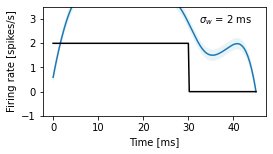

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernel5ms_filter_comp.pdf


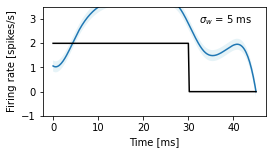

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernel8ms_filter_comp.pdf


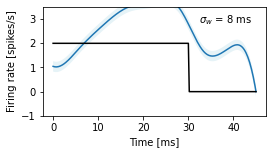

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernel10ms_filter_comp.pdf


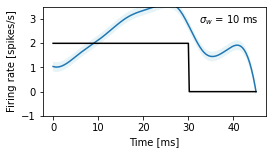

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernel15ms_filter_comp.pdf


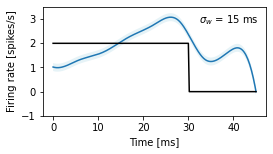

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernel20ms_filter_comp.pdf


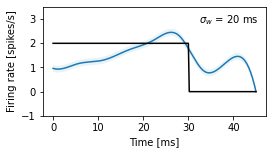

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernel25ms_filter_comp.pdf


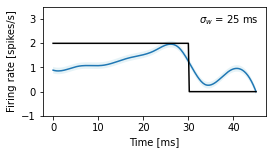

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernel30ms_filter_comp.pdf


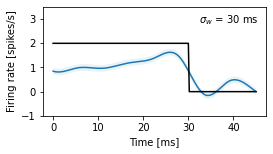

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernel40ms_filter_comp.pdf


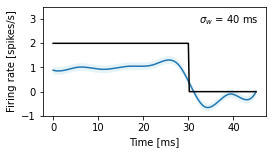

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernel60ms_filter_comp.pdf


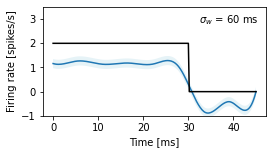

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernel80ms_filter_comp.pdf


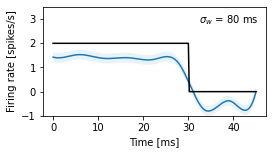

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernel100ms_filter_comp.pdf


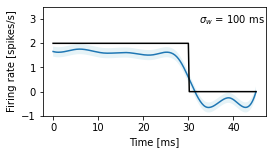

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernel120ms_filter_comp.pdf


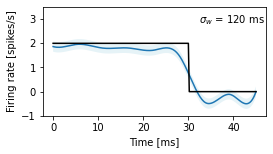

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernel130ms_filter_comp.pdf


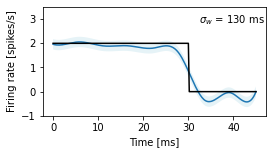

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernel140ms_filter_comp.pdf


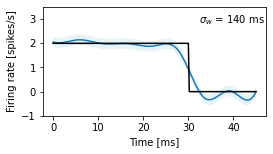

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernel160ms_filter_comp.pdf


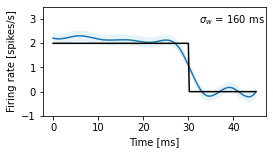

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernel200ms_filter_comp.pdf


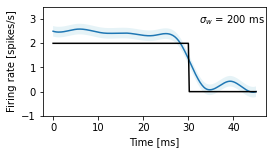

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernel250ms_filter_comp.pdf


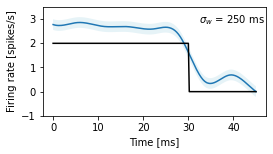

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernel300ms_filter_comp.pdf


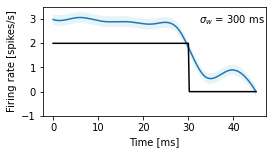

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernel500ms_filter_comp.pdf


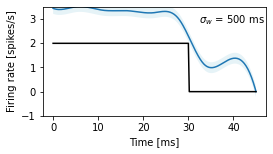

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernel800ms_filter_comp.pdf


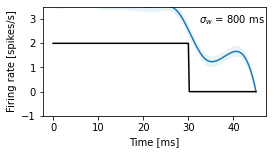

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernel1000ms_filter_comp.pdf


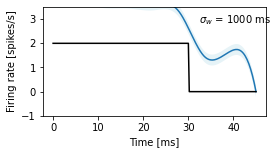

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_likelihood_loss_theoretical_numerical_kernelnanms_filter_comp.pdf


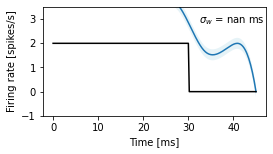

In [896]:
kernel_widths = [2, 5, 8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 130, 140, 160, 200, 250, 300, 500, 800, 1000, 'none']
model_paths = [0] * len(kernel_widths)
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bspline_'
for i, width in enumerate(kernel_widths):
    model_paths[i] = model_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'
experiment_name = f'{experiment_name}likelihood_loss_theoretical_numerical_'
output_dir = project_dir + 'Output/fig/'
jittertool.plot_bspline_filter_numerical(true_par, model_paths,
        experiment_name=experiment_name, output_dir=output_dir, verbose=False)

#### Laplacian window

theoretical roots: [0.01922855 0.12495191] 	nadir: 0.03906456874469359
num simulation models 100
save figure: D:/Brain_Network/Output/fig/poisson_background_laplacian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_bias.pdf


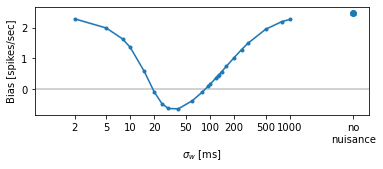

save figure: D:/Brain_Network/Output/fig/poisson_background_laplacian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_var.pdf


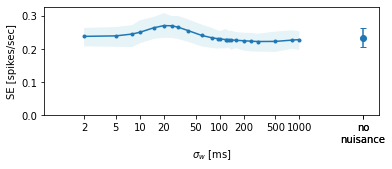

min_rmse_kernel_width: 0.1253409739683807
sim RMSE optimal sigma_w 0.095
save figure: D:/Brain_Network/Output/fig/poisson_background_laplacian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_rmse.pdf


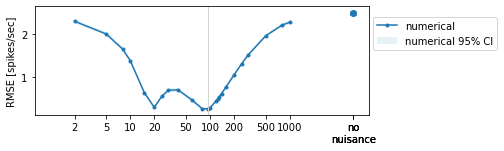

num simulation models 100
max_ll_kernel_width: 0.1
save figure: D:/Brain_Network/Output/fig/poisson_background_laplacian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_log_likelihood.pdf


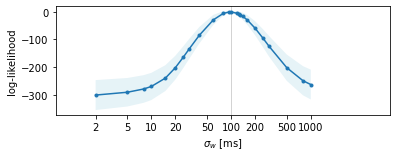

In [1682]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
Sxx_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_bases_inner_prod/'
experiment_name = 'poisson_background_laplacian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_'

file_path = data_dir + f'{experiment_name}generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
filter_true_val = generator_par['alpha'][0][1]
kernel_widths = [2, 5, 8, 10, 15, 20, 25, 30, 40, 60, 80, 95, 100, 120, 125, 130, 140, 160, 200, 250, 300, 500, 800, 1000, 'none']
model_paths = [0] * len(kernel_widths)
Sxx_paths = [0] * len(kernel_widths)

for i, width in enumerate(kernel_widths):
    model_paths[i] = model_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'
for i, width in enumerate(kernel_widths):
    Sxx_paths[i] = Sxx_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'

true_par = {'loss': 'none', 'filter_type': 'square', 'filter_length': 0.03,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': 10, 'mu': 30, 'rho': 30, 'background_window': 'gaussian', 
            'background_window_sigma': 0.1, 'trial_length': generator_par['trial_length'], 
            'num_trials': generator_par['num_trials'], 'alpha': generator_par['alpha'], 'beta': generator_par['beta']}

experiment_name = f'{experiment_name}likelihood_loss_theoretical_numerical_'
output_dir = project_dir + 'Output/fig/'
jittertool.plot_square_filter_beta_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=False,
        experiment_name=experiment_name, output_dir=output_dir)
jittertool.plot_likelihood_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=False,
        aligned_by='max', experiment_name=experiment_name, output_dir=output_dir)


#### Delayed input.

theoretical roots: [0.01922855 0.12495191] 	nadir: 0.03906456874469359
num simulation models 100
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delaysN20ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_bias.pdf


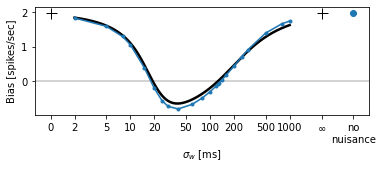

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delaysN20ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_var.pdf


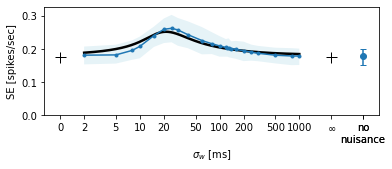

min_rmse_kernel_width: 0.1253409739683807
sim RMSE optimal sigma_w 0.14
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delaysN20ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_rmse.pdf


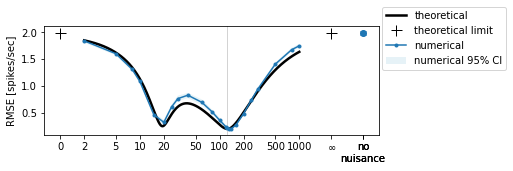

num simulation models 100
max_ll_kernel_width: 0.12137613437594817
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delaysN20ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_log_likelihood.pdf


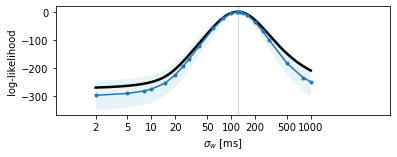

In [48]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
# experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delays20ms_trials200_nonrepeated_'
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delaysN20ms_trials200_nonrepeated_'

file_path = data_dir + f'{experiment_name}generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
filter_true_val = generator_par['alpha'][0][1]
kernel_widths = [2, 5, 8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 125, 130, 140, 160, 200, 250, 300, 500, 800, 1000, 'none']
model_paths = [0] * len(kernel_widths)

for i, width in enumerate(kernel_widths):
    model_paths[i] = model_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'

true_par = {'loss': 'none', 'filter_type': 'square', 'filter_length': 0.03,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'mu': 30, 'rho': 30, 'baseline': 10,  'background_window': 'gaussian', 
            'background_window_sigma': 0.1, 'trial_length': generator_par['trial_length'], 
            'num_trials': generator_par['num_trials'], 'alpha': generator_par['alpha'], 'beta': generator_par['beta']}

experiment_name = f'{experiment_name}likelihood_loss_theoretical_numerical_'
output_dir = project_dir + 'Output/fig/'
jittertool.plot_square_filter_beta_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=True,
        experiment_name=experiment_name, output_dir=output_dir)
jittertool.plot_likelihood_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=True,
        aligned_by='max', experiment_name=experiment_name, output_dir=output_dir)


D:/Brain_Network/Output/fig/shared_input_demo_1.pdf
D:/Brain_Network/Output/fig/shared_input_demo_2.pdf
D:/Brain_Network/Output/fig/shared_input_demo_3.pdf


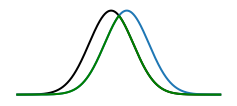

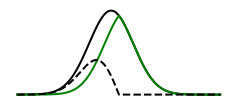

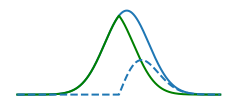

In [46]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
output_dir = project_dir + 'Output/fig/'
generator.delayed_shared_input_demo(output_dir=output_dir)

#### Sinusoid background

theoretical roots: [0.01922855 0.12495191] 	nadir: 0.03906456874469359
num simulation models 100
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delay16div64_trials200_nonrepeated_likelihood_loss_theoretical_numerical_bias.pdf


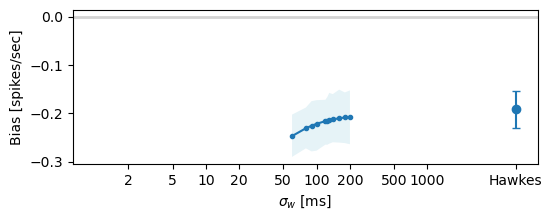

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delay16div64_trials200_nonrepeated_likelihood_loss_theoretical_numerical_var.pdf


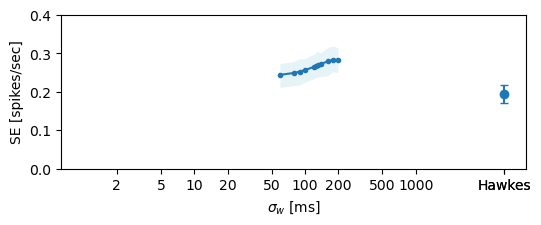

min_rmse_kernel_width: 0.1253409739683807
sim RMSE optimal sigma_w 0.09
empirical max is not shown
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delay16div64_trials200_nonrepeated_likelihood_loss_theoretical_numerical_rmse.pdf


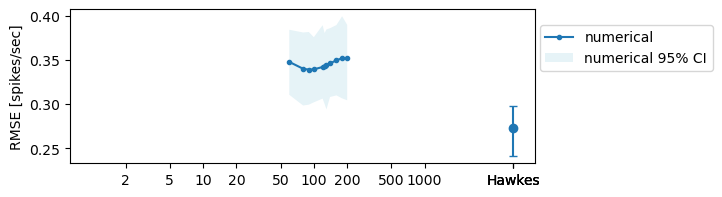

num simulation models 100
max_ll_kernel_width: 0.18015
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delay16div64_trials200_nonrepeated_likelihood_loss_theoretical_numerical_log_likelihood.pdf


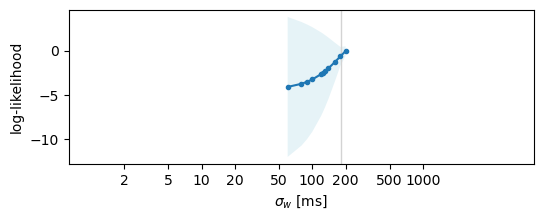

In [6]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
# experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delay12div64_trials200_'
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delay16div64_trials200_nonrepeated_'
# experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_sinusoid_amp10_freq05_delay32div64_trials200_nonrepeated_'
# experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_sinusoid_amp10_freq2_delay8div64_trials200_nonrepeated_'

file_path = data_dir + f'{experiment_name}generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
filter_true_val = generator_par['alpha'][0][1]
filter_length = generator_par['beta'][0][1]
# kernel_widths = [2, 5,  8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 140, 160, 200, 250, 300, 500, 800, 1000, 'none']
kernel_widths = [60,80,90,100,120,125,130,140,160,180,200,'none'] 
model_paths = [0] * len(kernel_widths)

for i, width in enumerate(kernel_widths):
    model_paths[i] = model_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'

true_par = {'loss': 'none', 'filter_type': 'square', 'filter_length': filter_length,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': 10, 'mu': 30, 'rho': 30, 'background_window': 'gaussian', 
            'background_window_sigma': 0.1, 'trial_length': generator_par['trial_length'], 
            'num_trials': generator_par['num_trials'], 'alpha': generator_par['alpha'], 'beta': generator_par['beta']}

experiment_name = f'{experiment_name}likelihood_loss_theoretical_numerical_'
output_dir = project_dir + 'Output/fig/'
jittertool.plot_square_filter_beta_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=False,
        experiment_name=experiment_name, output_dir=output_dir)
jittertool.plot_likelihood_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=False,
        aligned_by='max', experiment_name=experiment_name, output_dir=output_dir, verbose=False)


In [22]:
# Plot as a function of correlation.

jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'

lags = np.array([0,2,4,6,8,10,12,14,16,18,20,24,28,32])
# lags = np.array([0,4,8,12,16,20,24,28,32])
# lags = np.array([0,4,8,12,16,20,24,28,32])

bias_model_list = np.zeros(len(lags))
bias_hawkes_list = np.zeros(len(lags))
bias_model_all_list = [0] * len(lags)
bias_hawkes_all_list = [0] * len(lags)

for lag_id, lag_integer in enumerate(lags):
    experiment_name = f'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma_100ms_delay{lag_integer}div64_trials200_'
    file_path = data_dir + f'{experiment_name}generator_par.pkl'
    generator_par = util.load_variable(file_path, verbose=False)
    trial_length = generator_par['trial_length']
    filter_true_val = generator_par['alpha'][0][1]
    filter_length = generator_par['beta'][0][1]

    if lag_integer in [10, 12]:
        kernel_widths = [140, 'none']
    elif lag_integer in [14]:
        kernel_widths = [200, 'none']
    elif lag_integer in [18]:
        kernel_widths = [160, 'none']
    elif lag_integer in [16]:
        kernel_widths = [1200, 'none']
    else:
        kernel_widths = [120, 'none']

    model_paths = [0] * len(kernel_widths)
    for i, width in enumerate(kernel_widths):
        model_paths[i] = model_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'
    true_par = {'loss': 'none', 'filter_type': 'square', 'filter_length': filter_length,
                'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
                'baseline': 10, 'mu': 30, 'rho': 30, 'background_window': 'gaussian', 
                'background_window_sigma': 0.1, 'trial_length': generator_par['trial_length'], 
                'num_trials': generator_par['num_trials'], 'alpha': generator_par['alpha'], 'beta': generator_par['beta']}
    experiment_name = f'{experiment_name}likelihood_loss_theoretical_numerical_'
    output_dir = project_dir + 'Output/fig/'
    _,bias,bias_all,bias_hawkes,bias_hawkes_all,_,_,_,_ \
        = jittertool.plot_square_filter_beta_theoretical_vs_numerical(true_par, filter_true_val, model_paths, show_theoretical=False,
            experiment_name=experiment_name, output_dir=None)

    bias_model_list[lag_id] = bias[0]  # little trick
    bias_model_all_list[lag_id] = bias_all[0]
    bias_hawkes_list[lag_id] = bias_hawkes
    bias_hawkes_all_list[lag_id] = bias_hawkes_all
    print('---------bias model, hawkes', bias[0], bias_hawkes)


theoretical roots: [0.01922855 0.12495191] 	nadir: 0.03906456874469359
num simulation models 100
min_rmse_kernel_width: 0.1253409739683807
sim RMSE optimal sigma_w nan
empirical max is not shown
---------bias model, hawkes -0.08184021145819598 1.516587643380404
theoretical roots: [0.01922855 0.12495191] 	nadir: 0.03906456874469359
num simulation models 100
min_rmse_kernel_width: 0.1253409739683807
sim RMSE optimal sigma_w nan
empirical max is not shown
---------bias model, hawkes -0.10473934043641075 1.4687744250437436
theoretical roots: [0.01922855 0.12495191] 	nadir: 0.03906456874469359
num simulation models 100
min_rmse_kernel_width: 0.1253409739683807
sim RMSE optimal sigma_w nan
empirical max is not shown
---------bias model, hawkes -0.12260112173066173 1.361816719757547
theoretical roots: [0.01922855 0.12495191] 	nadir: 0.03906456874469359
num simulation models 100
min_rmse_kernel_width: 0.1253409739683807
sim RMSE optimal sigma_w nan
empirical max is not shown
---------bias mode

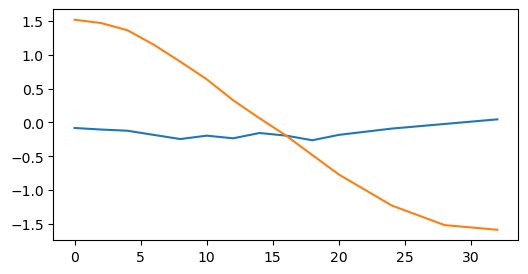

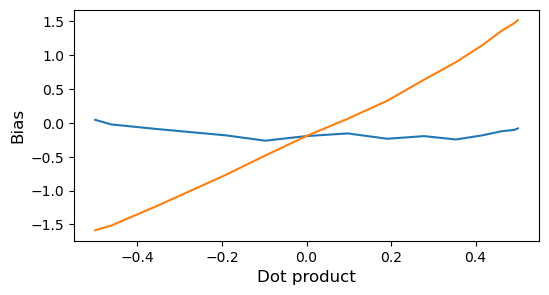

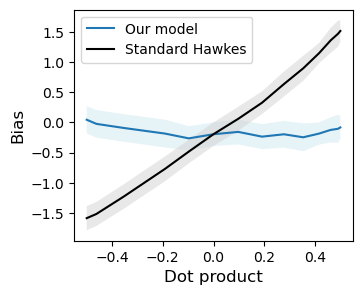

In [23]:
def calculate_dot_prod(shift, freq=1, T=5, dt=0.001):
    t = np.arange(0,T+dt,dt)
    y1 = np.sin(2*np.pi*freq*t)
    y2 = np.sin(2*np.pi*freq*(t-shift))
    corr = np.dot(y1, y2) * dt / T
    return corr
# freq = 1
# phase = np.linspace(0,1/2/freq,50)
# corr = np.zeros_like(phase)
# for i, shift in enumerate(phase):
#     corr[i] = calculate_dot_prod(shift)
# plt.plot(phase, corr)
# plt.grid()
corr = np.zeros(len(lags))
for i, lag in enumerate(lags):
    shift = lag /2 / 32
    corr[i] = calculate_dot_prod(shift, freq=1, T=5, dt=0.001)
    
bias_model_all_mat = np.stack(bias_model_all_list)
bias_hawkes_all_mat = np.stack(bias_hawkes_all_list)

plt.figure(figsize=[6,3])
plt.plot(lags, bias_model_list)
plt.plot(lags, bias_hawkes_list)

plt.figure(figsize=[6,3])
plt.plot(corr, bias_model_list)
plt.plot(corr, bias_hawkes_list)
plt.xlabel('Dot product', fontsize=12)
plt.ylabel('Bias', fontsize=12)


plt.figure(figsize=[3.6,3])
plt.plot(corr, bias_model_all_mat.mean(axis=1), c='tab:blue', label='Our model')
plt.fill_between(corr, bias_model_all_mat.mean(axis=1)-bias_model_all_mat.std(axis=1), bias_model_all_mat.mean(axis=1)+bias_model_all_mat.std(axis=1),
        facecolor='lightblue', alpha=0.3)

plt.plot(corr, bias_hawkes_all_mat.mean(axis=1), c='k', label='Standard Hawkes')
plt.fill_between(corr, bias_hawkes_all_mat.mean(axis=1)-bias_hawkes_all_mat.std(axis=1), bias_hawkes_all_mat.mean(axis=1)+bias_hawkes_all_mat.std(axis=1),
        facecolor='lightgrey', alpha=0.5)

plt.xlabel('Dot product', fontsize=12)
plt.ylabel('Bias', fontsize=12)
plt.legend(); 
plt.savefig(project_dir + 'Output/fig/bias_vs_dotprod.pdf', bbox_inches='tight')
plt.show()


#### Distribution normality

num simulation models 100	kernel_width 0.12


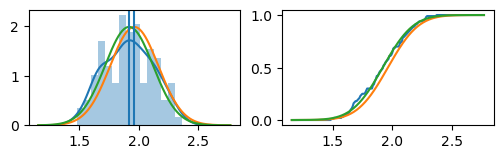

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_lik_loss_kernel120ms_QQ_plot.pdf


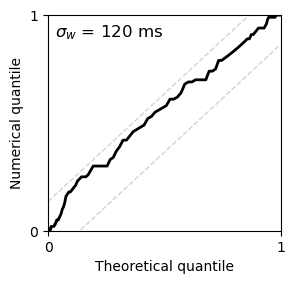

In [122]:
width = 120
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_'
model_path = model_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'
true_par = {'loss': 'none', 'filter_type': 'square', 'filter_length': 0.03,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': 10, 'mu': 30, 'rho': 30, 'background_window': 'gaussian', 
            'background_window_sigma': 0.1, 'trial_length': generator_par['trial_length'], 
            'num_trials': generator_par['num_trials'], 'alpha': generator_par['alpha'], 'beta': generator_par['beta']}
experiment_name = f'{experiment_name}lik_loss_'
jittertool.plot_beta_qq_plot(true_par, model_path, correct_center=False, experiment_name=experiment_name, output_dir=output_dir)


# Plug-in estimator based on Sxx.

  0%|                                                                         | 0/1 [00:00<?, ?it/s]optimal kernel width  130.0


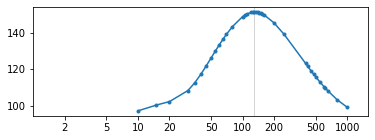

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.67s/it]


In [946]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_bases_inner_prod/'
model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated'
file_path = data_dir + f'{model_name}_generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']

# model_par = {'dt': 0.001, 'filter_type': 'square', 'filter_length': 0.03, 'trial_window': [0, trial_length],
#              'append_nuisance': ['const', 'gaussian_kernel'], 'baseline': generator_par['baseline'], 
#              'mu': generator_par['mu'], 'rho': generator_par['rho'],
#              'background_window': generator_par['window'], 'background_window_sigma': generator_par['sigma'],
#              'const_offset': 0, 'alpha': generator_par['alpha'], 'beta': generator_par['beta']}

num_itrs = 1
trange = tqdm(range(num_itrs), ncols=100, file=sys.stdout)
for itr in trange:
    file_path = data_dir + f'{model_name}_itr{itr}.pkl'
    spike_times = util.load_variable(file_path, verbose=False)
    spike_times_x, spike_times_y = spike_times[1], spike_times[0]
    model_par = {'dt': 0.001, 'trial_window': [0, trial_length], 'append_nuisance': ['const', 'gaussian_kernel']}
    jittertool.estimate_optimal_jitter_window_width(spike_times_x[:50], spike_times_y[:50], model_par)
#     model_par = {'dt': 0.001, 'trial_window': [0, trial_length], 'append_nuisance': ['const', 'triangle_kernel']}
#     jittertool.estimate_optimal_jitter_window_width(spike_times_x[:50], spike_times_y[:50], model_par)


#### create data with different $\sigma_I$

In [955]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
generator_par = {'num_trials': 100, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 30, 'mu': 30, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.12, 'random_seed': 222,
    'type': 'square', 'alpha': [[0., 2], [0.0, 0.0]], 'beta': [[1.0, 0.03], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=2)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

100%|█████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.32it/s]


In [ ]:
model_par = {'dt': 0.001, 'trial_window': [0, trial_length], 'append_nuisance': ['const', 'gaussian_kernel']}
jittertool.estimate_optimal_jitter_window_width(spike_times_x, spike_times_y, model_par)
model_par = {'dt': 0.001, 'trial_window': [0, trial_length], 'append_nuisance': ['const', 'triangle_kernel']}
jittertool.estimate_optimal_jitter_window_width(spike_times_x, spike_times_y, model_par)

# S_ww, S_wh, S_hh

In [1621]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
Sxx_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_bases_inner_prod/'
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_'

file_path = data_dir + f'{experiment_name}generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
filter_true_val = generator_par['alpha'][0][1]
filter_length = generator_par['beta'][0][1]
kernel_widths = [2, 5,  8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 140, 160, 200, 250, 300, 500, 800, 1000,]
model_paths = [0] * len(kernel_widths)
Sxx_paths = [0] * len(kernel_widths)

for i, width in enumerate(kernel_widths):
    model_paths[i] = model_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'
for i, width in enumerate(kernel_widths):
    Sxx_paths[i] = Sxx_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'


In [ ]:
jittertool.plot_likelihood_theoretical_vs_numerical_derivation(true_par, filter_true_val, Sxx_paths,
        experiment_name=experiment_name, output_dir=output_dir)


#### Calculate Sxx and save.

In [406]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_bases_inner_prod/'
model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated'
file_path = data_dir + f'{model_name}_generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']

num_itrs = 100
# kernel_widths = [2, 5, 8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 140, 160, 200, 250, 300, 500, 800, 1000]
kernel_widths = [125]

for kernel_width in kernel_widths:
    model_par_list = []
    model_par = {'dt': 0.001, 'filter_type': 'square', 'filter_length': 0.03,
                 'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': kernel_width/1000,
                 'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}

    trange = tqdm(range(num_itrs), ncols=100, file=sys.stdout)
    for itr in trange:
        file_path = data_dir + f'{model_name}_itr{itr}.pkl'
        spike_times = util.load_variable(file_path, verbose=False)
        spike_times_x, spike_times_y = spike_times[1], spike_times[0]
        model_par_hat = jittertool.bivariate_discrete_time_coupling_filter_regression_bases(
                spike_times_x, spike_times_y, [0,trial_length], model_par, verbose=False)
        model_par_list.append(model_par_hat)

#     file_path = model_dir + f'{model_name}_kernel{kernel_width}ms_model_par_list.pkl'
#     util.save_variable(file_path, model_par_list)

100%|█████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.90it/s]


#### Theoretical

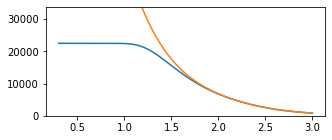

In [95]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_bases_inner_prod/'
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_'
file_path = data_dir + f'{experiment_name}generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
true_par = {'filter_type': 'square', 'filter_length': 0.03,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': 10, 'mu': 30, 'rho': 30, 'background_window': 'gaussian', 
            'background_window_sigma': 0.1, 'trial_length': generator_par['trial_length'], 
            'num_trials': generator_par['num_trials'], 'alpha': generator_par['alpha'], 'beta': generator_par['beta']}

jittertool.plot_Sxx_theoretical(true_par)

#### Theoretical v.s. numerical

num simulation models 100
S_xx.shape (100, 4, 4)
Sxx mean [5663700. 2316600. 1480000. 1201200.  829400.  643400.  531600.  456600.  362100.  264600.  213000.  180100.
  157100.  140000.  126900.  108200.   93400.   83800.   66700.   58000.   53000.]
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bases_theoretical_numerical_Sxx_1_1.pdf


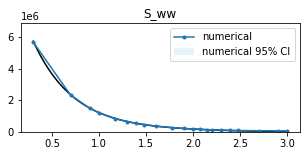

num simulation models 100
S_xx.shape (100, 4, 4)
Sxx mean [1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300.
 1300. 1300. 1300.]
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bases_theoretical_numerical_Sxx_2_2.pdf


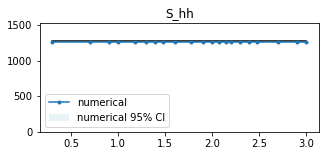

num simulation models 100
S_xx.shape (100, 4, 4)
Sxx mean [18400. 20800. 21400. 21500. 21000. 19400. 17600. 16000. 13300. 10000.  8100.  6900.  6000.  5300.  4800.
  4000.  3300.  2900.  1800.  1200.  1000.]
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_bases_theoretical_numerical_Sxx_1_2.pdf


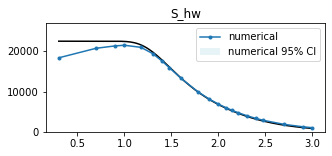

In [999]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_bases_inner_prod/'
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_'
file_path = data_dir + f'{experiment_name}generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
kernel_widths = [2, 5, 8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 140, 160, 200, 250, 300, 500, 800, 1000]

model_paths = [0] * len(kernel_widths)

for i, width in enumerate(kernel_widths):
    model_paths[i] = model_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'

true_par = {'filter_type': 'square', 'filter_length': 0.03,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': 10, 'mu': 30, 'rho': 30, 'background_window': 'gaussian', 
            'background_window_sigma': 0.1, 'trial_length': generator_par['trial_length'], 
            'num_trials': generator_par['num_trials'], 'alpha': generator_par['alpha'], 'beta': generator_par['beta']}
experiment_name = f'{experiment_name}bases_theoretical_numerical_'
output_dir = project_dir + 'Output/fig/'
jittertool.plot_Sxx_theoretical_vs_numerical(1,1,true_par, model_paths, experiment_name, output_dir=output_dir)
jittertool.plot_Sxx_theoretical_vs_numerical(2,2,true_par, model_paths, experiment_name, output_dir=output_dir)
jittertool.plot_Sxx_theoretical_vs_numerical(1,2,true_par, model_paths, experiment_name, output_dir=output_dir)
# jittertool.plot_Sxx_theoretical_vs_numerical(1,4,true_par, model_paths, experiment_name, output_dir=output_dir)
# jittertool.plot_Sxx_theoretical_vs_numerical(2,4,true_par, model_paths, experiment_name, output_dir=output_dir)
# jittertool.plot_Sxx_theoretical_vs_numerical(1,3,true_par, model_paths, experiment_name, output_dir=output_dir)
# jittertool.plot_Sxx_theoretical_vs_numerical(2,3,true_par, model_paths, experiment_name, output_dir=output_dir)


# Estimation of covariace density.
This has been replaced by the plug-in estimator.

  0%|                                                                         | 0/5 [00:00<?, ?it/s]
200 39.975

200 39.678
 40%|██████████████████████████                                       | 2/5 [00:00<00:00, 13.55it/s]
200 39.473

200 39.554
 80%|████████████████████████████████████████████████████             | 4/5 [00:00<00:00, 13.86it/s]
200 39.763999999999996
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.28it/s]


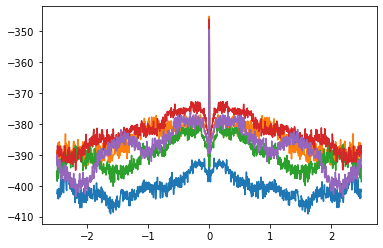

In [291]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated'
file_path = data_dir + f'{model_name}_generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']

num_itrs = 5

model_par_list = []
model_par = {'dt': 0.005, 
             'filter_type': 'square', 'filter_length': 0.03, 'trial_window': [0, trial_length],
             'append_nuisance': ['const', 'gaussian_kernel']}

trange = tqdm(range(num_itrs), ncols=100, file=sys.stdout)
for itr in trange:
    file_path = data_dir + f'{model_name}_itr{itr}.pkl'
    spike_times = util.load_variable(file_path, verbose=False)
    spike_times_x, spike_times_y = spike_times[1], spike_times[0]
    model_par_hat = jittertool.estimate_covariance_density(spike_times_x, model_par)

#     model_par_list.append(model_par_hat)
# file_path = model_dir + f'{model_name}_kernel{kernel_width}ms_model_par_list.pkl'
# util.save_variable(file_path, model_par_list)

# L2 loss (discrete)

#### Data fitting.

In [ ]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_L2_regression/'
model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated'
file_path = data_dir + f'{model_name}_generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']

num_itrs = 100
kernel_widths = [2, 5, 8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 140, 160, 200, 250, 300, 500, 800, 1000]

for kernel_width in kernel_widths:
    model_par_list = []
#     model_par = {'dt': 0.001, 'filter_type': 'square', 'filter_length': 0.03,
#                  'append_nuisance': ['const'],
#                  'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}
    model_par = {'dt': 0.001, 'filter_type': 'square', 'filter_length': 0.03,
                 'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': kernel_width/1000,
                 'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}

    trange = tqdm(range(num_itrs), ncols=100, file=sys.stdout)
    for itr in trange:
        file_path = data_dir + f'{model_name}_itr{itr}.pkl'
        spike_times = util.load_variable(file_path, verbose=False)
        spike_times_x, spike_times_y = spike_times[1], spike_times[0]
        model_par_hat = jittertool.bivariate_discrete_time_coupling_filter_regression_L2_loss(
                spike_times_x, spike_times_y, [0,trial_length], model_par)
        model_par_list.append(model_par_hat)

    file_path = model_dir + f'{model_name}_kernel{kernel_width}ms_model_par_list.pkl'
    util.save_variable(file_path, model_par_list)

#### Plot the results.

theoretical roots: [0.01922855 0.12495191] 	nadir: 0.03906456874469359
num simulation models 100
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_bias.pdf


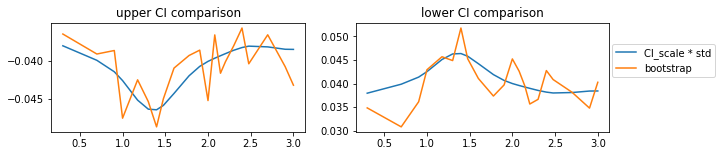

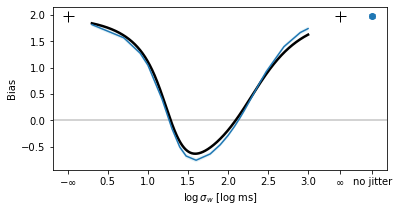

save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_var.pdf


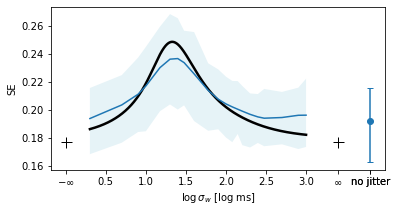

min_rmse_kernel_width: 0.1253409739683807
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_likelihood_loss_theoretical_numerical_rmse.pdf


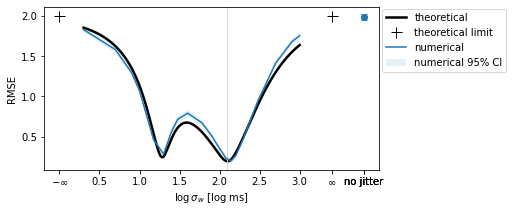

In [130]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_L2_regression/'
model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated'
file_path = data_dir + f'{model_name}_generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']
filter_true_val = generator_par['alpha'][0][1]

filter_true_val = 2
kernel_widths = [2, 5, 8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 140, 160, 200, 250, 300, 500, 800, 1000, 'none']

model_paths = [0] * len(kernel_widths)
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_'
for i, width in enumerate(kernel_widths):
    model_paths[i] = model_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'
    
true_par = {'loss': 'L2', 'filter_type': 'square', 'filter_length': 0.03,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': 10, 'mu': 30, 'rho': 30, 'background_window': 'gaussian', 
            'background_window_sigma': 0.1, 'trial_length': generator_par['trial_length'], 
            'num_trials': generator_par['num_trials']}
experiment_name = f'{experiment_name}likelihood_loss_theoretical_numerical_'
output_dir = project_dir + 'Output/fig/'
jittertool.plot_square_filter_beta_theoretical_vs_numerical(true_par, filter_true_val, model_paths,
        experiment_name=experiment_name, output_dir=output_dir)


#### Compare L2 loss and likelihood loss.

roots: [0.01894706 0.12339613] 	nadir: 0.03885822984734588


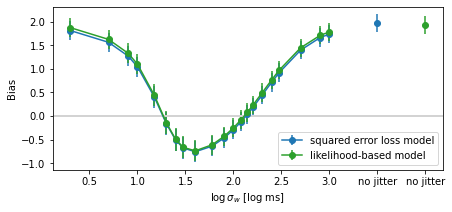

In [62]:
filter_true_val = 2
kernel_widths = [2, 5, 8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 140, 160, 200, 250, 300, 500, 800, 1000, 'none']
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_L2_regression/'
model_paths = [0] * len(kernel_widths)
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_'
for i, width in enumerate(kernel_widths):
    model_paths[i] = model_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'

kernel_widths = [2, 5, 8, 10, 15, 20, 25, 30, 40, 60, 80, 100, 120, 140, 160, 200, 250, 300, 500, 800, 1000, 'none']
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_likelihood_regression/'
model_paths2 = [0] * len(kernel_widths)
experiment_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_'
for i, width in enumerate(kernel_widths):
    model_paths2[i] = model_dir + experiment_name + f'kernel{width}ms_model_par_list.pkl'

true_par = {'loss': 'L2', 'filter_type': 'square', 'filter_length': 0.03,
            'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': [0.002, 1],
            'baseline': 10, 'mu': 30, 'rho': 30, 'background_window': 'gaussian', 'background_window_sigma': 0.1}
file_path = project_dir + f'Output/fig/{experiment_name}bias_numerical_L2_likelihood_comparison.pdf'
jittertool.plot_bias_numerical_comparison(true_par, filter_true_val, model_paths, model_paths2, file_path=None)

### Approximation of $\frac{1}{1-x}$

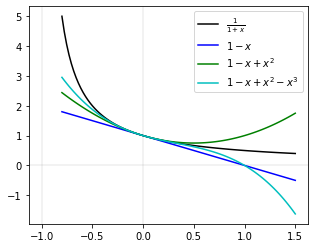

In [1501]:
x = np.linspace(-0.8, 1.5, 100)
y = 1/(1+x)
y1 = 1 - x
y2 = 1 - x + x**2
y3 = 1 - x + x**2 - x**3
plt.figure(figsize=[5, 4])
plt.axhline(0, c='grey',lw=0.2); plt.axvline(0, c='grey',lw=0.2); plt.axvline(-1, c='grey',lw=0.2); 
plt.plot(x, y, 'k', lw=1.5, label=r'$\frac{1}{1+x}$')
plt.plot(x, y1, 'b', lw=1.5, label=r'$1-x$')
plt.plot(x, y2, 'g', lw=1.5, label=r'$1-x+x^2$')
plt.plot(x, y3, 'c', lw=1.5, label=r'$1-x+x^2-x^3$')
plt.legend()
# plt.axis('equal')
file_path = project_dir + 'Output/fig/taylor_approx.pdf'
plt.savefig(file_path)

#### Approximation of erf function.

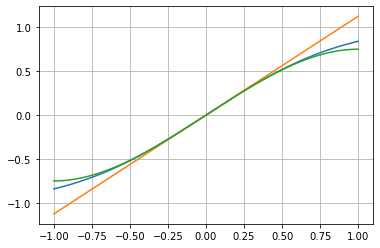

In [92]:
x = np.linspace(-1, 1, 1000)
y = jittertool.erf(x)
yhat1 = 2/np.sqrt(np.pi)*x
yhat2 = 2/np.sqrt(np.pi)*(x - x**3/3)
plt.plot(x,y)
plt.plot(x,yhat1)
plt.plot(x,yhat2)
plt.grid()